## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn, combine_results
from utils.analysis_utils import combine_results
from edit_knn import main as edit

In [3]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [12]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
# key_image_id = 'dog-train-n02114712_211'
target_class_name = 'dog'

analyze_in_edit = True
# paths_dir = os.path.join('paths', 'edits', key_image_id)
paths_dir = os.path.join('paths', 'edits', target_class_name, '0112_114547')

key_image_paths = read_lists(os.path.join(paths_dir, 'key_images.txt'))
value_image_paths = read_lists(os.path.join(paths_dir, 'value_images.txt'))
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

# value_image_paths = [
#     os.path.join(paths_dir, 'value_images.txt')
# ]
# n_trials = len(value_image_paths)

# key_image_paths = [os.path.join(paths_dir, 'key_images.txt')]

In [5]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

target_class_idx = class_idx_dict[target_class_name]
# Set K
K = config_dict['editor']['K']

# Obtain target class

# config = ConfigParser(config_dict)

device, device_ids = prepare_device(config_dict['n_gpu'])

In [6]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [7]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/progress_report.txt


### Ensure all paths for keys and values exist

In [8]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))

## Run edit for each modified image

Starting Trial 1/37...
Current run_id: 0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712_211/modified_images/felzenszwalb_gaussian_0.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|██████████████████████████████████████████| 274/274 [09:18<00:00,  2.04s/it]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06699194014072418 0.004417340271174908
L2 norm of weight change: 0.23246465623378754
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:20<00:00,  1.96it/s]


Post-edit metrics: {'TP': array([6121, 5282, 5387, 4000, 4311, 3114, 4979, 5174, 4893, 4617]), 'TN': array([60130, 61313, 58642, 59548, 59907, 61510, 62194, 61670, 61532,
       61432]), 'FPs': array([2870, 1687, 4358, 3452, 3093, 1490,  806, 1330, 1468, 1568]), 'FNs': array([ 879, 1718, 1613, 3000, 2689, 3886, 2021, 1826, 2107, 2383]), 'accuracy': 0.6839714285714286, 'per_class_accuracy': array([0.94644286, 0.95135714, 0.9147    , 0.90782857, 0.9174    ,
       0.9232    , 0.95961429, 0.95491429, 0.94892857, 0.94355714]), 'per_class_accuracy_mean': 0.9367942857142857, 'precision': array([0.6807919 , 0.75792797, 0.55279631, 0.53676865, 0.58225284,
       0.67636838, 0.86067416, 0.79551046, 0.76921868, 0.74648343]), 'precision_mean': 0.6958792756227083, 'recall': array([0.87442857, 0.75457143, 0.76957143, 0.57142857, 0.61585714,
       0.44485714, 0.71128571, 0.73914286, 0.699     , 0.65957143]), 'recall_mean': 0.6839714285714285, 'f1': array([0.76555563, 0.75624597, 0.64341595, 0.55355

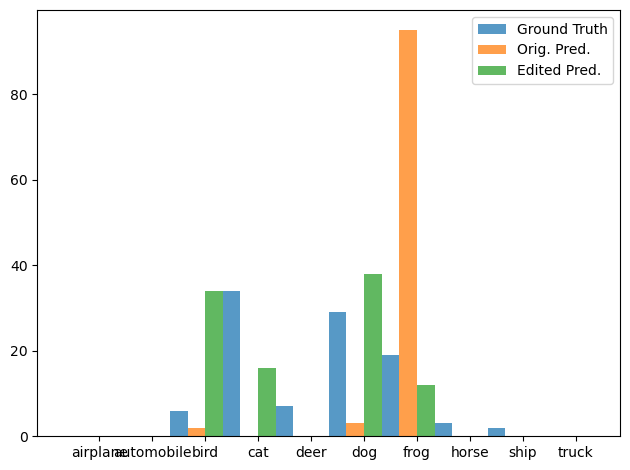

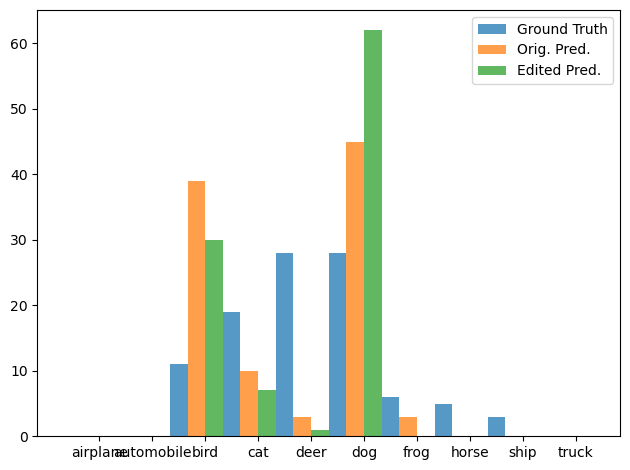

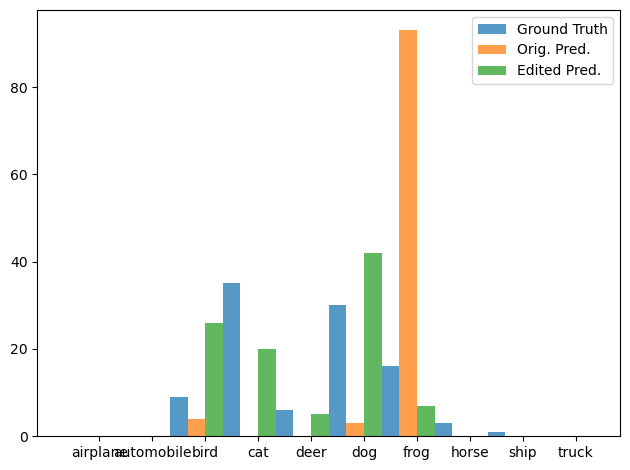

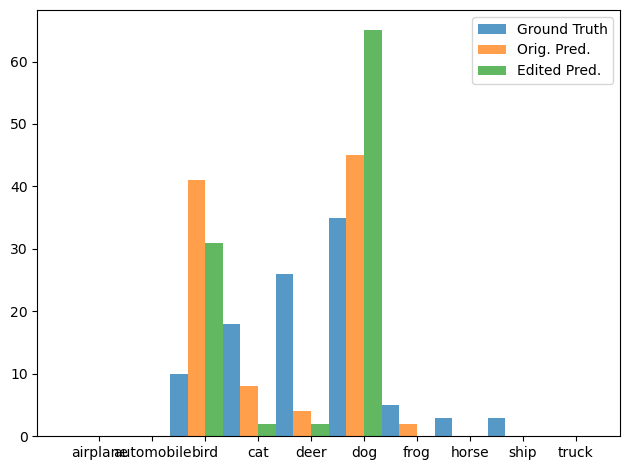

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models
Finished trial 1/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0
Starting Trial 2/37...
Current run_id: 0112_121958/dog-train-n02114712_211/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712

100%|██████████████████████████████████████████| 274/274 [02:16<00:00,  2.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06650909781455994 0.003841985482722521
L2 norm of weight change: 0.22643405199050903
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:40<00:00,  2.74it/s]


Post-edit metrics: {'TP': array([6107, 5342, 5350, 4044, 4207, 3240, 5048, 5187, 4901, 4595]), 'TN': array([60218, 61207, 58910, 59432, 60209, 61271, 62145, 61655, 61532,
       61442]), 'FPs': array([2782, 1793, 4090, 3568, 2791, 1729,  855, 1345, 1468, 1558]), 'FNs': array([ 893, 1658, 1650, 2956, 2793, 3760, 1952, 1813, 2099, 2405]), 'accuracy': 0.6860142857142857, 'per_class_accuracy': array([0.9475    , 0.9507    , 0.918     , 0.9068    , 0.92022857,
       0.92158571, 0.9599    , 0.95488571, 0.94904286, 0.94338571]), 'per_class_accuracy_mean': 0.937202857142857, 'precision': array([0.68702891, 0.74870357, 0.56673729, 0.53126642, 0.60117176,
       0.65204266, 0.85515839, 0.79409063, 0.76950856, 0.74679018]), 'precision_mean': 0.6952498389027806, 'recall': array([0.87242857, 0.76314286, 0.76428571, 0.57771429, 0.601     ,
       0.46285714, 0.72114286, 0.741     , 0.70014286, 0.65642857]), 'recall_mean': 0.6860142857142857, 'f1': array([0.76870791, 0.75585426, 0.65085158, 0.553517

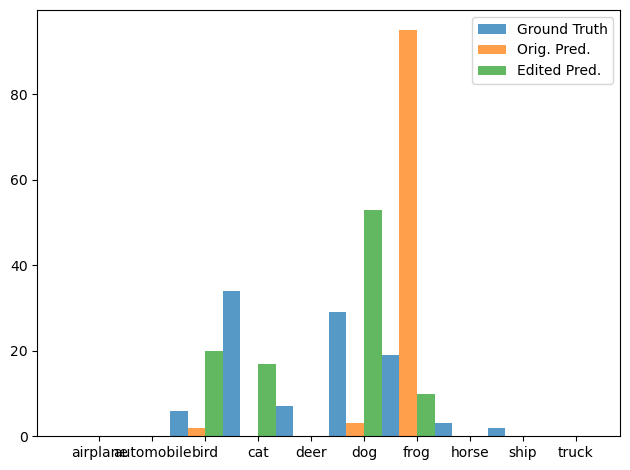

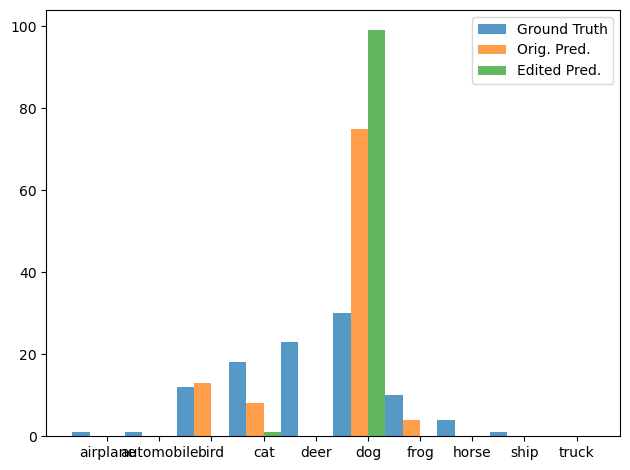

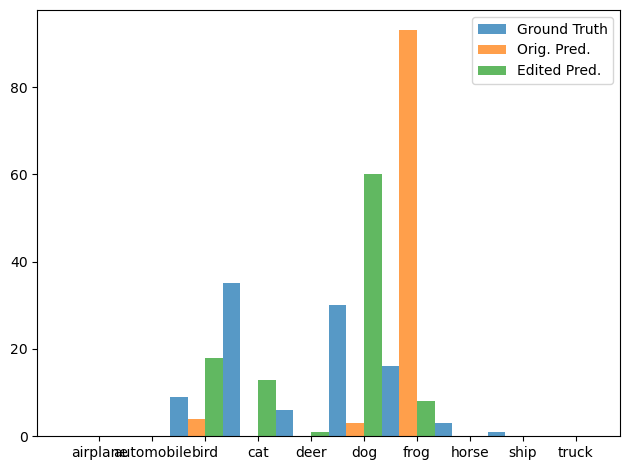

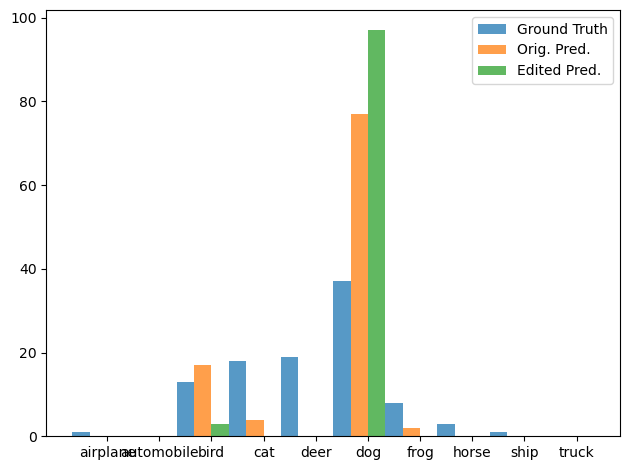

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_0/models
Finished trial 2/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_0
Starting Trial 3/37...
Current run_id: 0112_121958/dog-train-n02114712_211/felzenszwalb_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712_211/m

100%|██████████████████████████████████████████| 274/274 [01:46<00:00,  2.58it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.10497642308473587 0.0034171666484326124
L2 norm of weight change: 0.37952035665512085
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:02<00:00,  2.24it/s]


Post-edit metrics: {'TP': array([6039, 5504, 5377, 3577, 3758, 4051, 4228, 5258, 4835, 4382]), 'TN': array([60527, 60897, 58849, 60381, 61225, 57568, 62724, 61534, 61612,
       61692]), 'FPs': array([2473, 2103, 4151, 2619, 1775, 5432,  276, 1466, 1388, 1308]), 'FNs': array([ 961, 1496, 1623, 3423, 3242, 2949, 2772, 1742, 2165, 2618]), 'accuracy': 0.6715571428571429, 'per_class_accuracy': array([0.95094286, 0.94858571, 0.91751429, 0.91368571, 0.92832857,
       0.88027143, 0.95645714, 0.95417143, 0.94924286, 0.94391429]), 'per_class_accuracy_mean': 0.9343114285714286, 'precision': array([0.70946898, 0.7235441 , 0.56433669, 0.57730794, 0.67919754,
       0.42718549, 0.93872114, 0.78197501, 0.77695645, 0.77012302]), 'precision_mean': 0.6948816379742568, 'recall': array([0.86271429, 0.78628571, 0.76814286, 0.511     , 0.53685714,
       0.57871429, 0.604     , 0.75114286, 0.69071429, 0.626     ]), 'recall_mean': 0.6715571428571429, 'f1': array([0.778623  , 0.75361128, 0.65065344, 0.54213

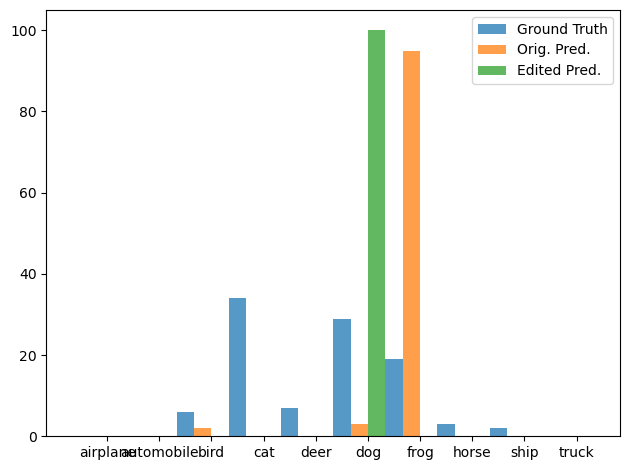

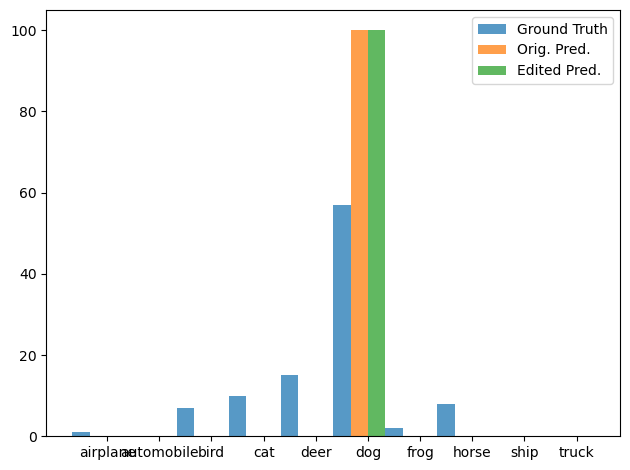

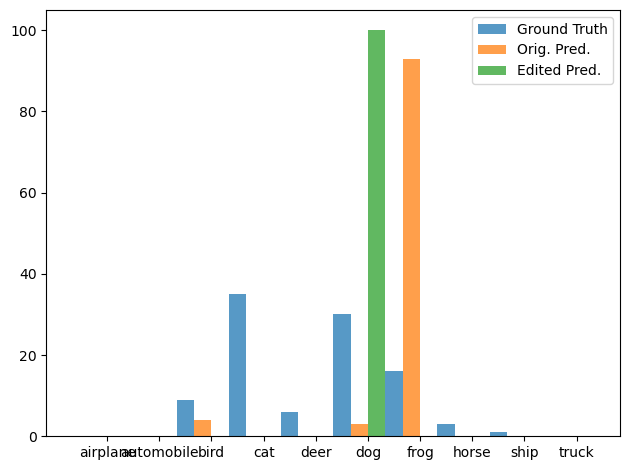

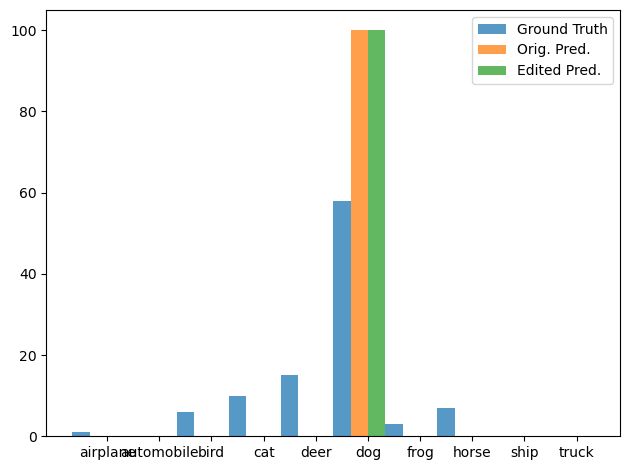

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_1/models
Finished trial 3/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_masked_1
Starting Trial 4/37...
Current run_id: 0112_121958/dog-train-n02114712_211/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712_211/modif

100%|██████████████████████████████████████████| 274/274 [01:08<00:00,  4.03it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.039724767208099365 0.00422267708927393
L2 norm of weight change: 0.16770800948143005
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:39<00:00,  2.76it/s]


Post-edit metrics: {'TP': array([6116, 5355, 5286, 4127, 4047, 3117, 5382, 5172, 4818, 4680]), 'TN': array([60217, 61200, 59161, 59159, 60590, 61487, 61641, 61703, 61662,
       61280]), 'FPs': array([2783, 1800, 3839, 3841, 2410, 1513, 1359, 1297, 1338, 1720]), 'FNs': array([ 884, 1645, 1714, 2873, 2953, 3883, 1618, 1828, 2182, 2320]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94761429, 0.95078571, 0.92067143, 0.90408571, 0.92338571,
       0.92291429, 0.95747143, 0.95535714, 0.94971429, 0.94228571]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.68726823, 0.74842767, 0.57928767, 0.51794679, 0.62676165,
       0.67321814, 0.79839786, 0.79950533, 0.78265107, 0.73125   ]), 'precision_mean': 0.6944714429361001, 'recall': array([0.87371429, 0.765     , 0.75514286, 0.58957143, 0.57814286,
       0.44528571, 0.76885714, 0.73885714, 0.68828571, 0.66857143]), 'recall_mean': 0.6871428571428572, 'f1': array([0.76935656, 0.7566231 , 0.65562791, 0.55144

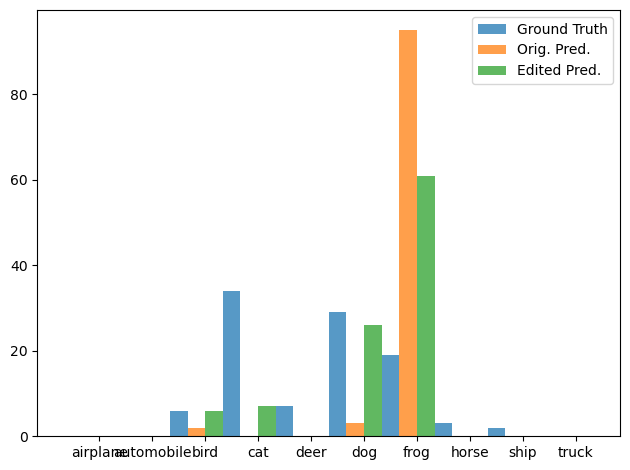

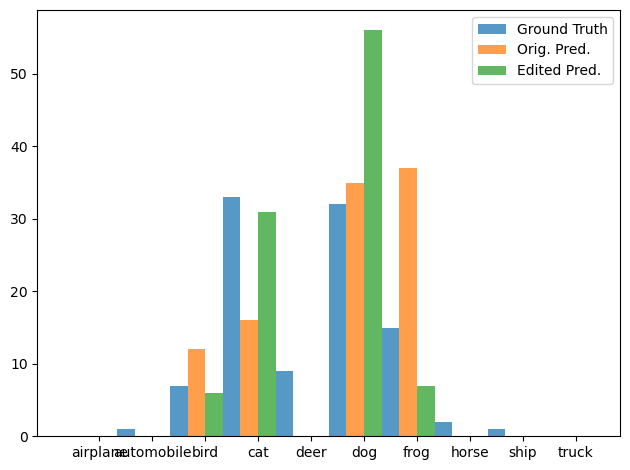

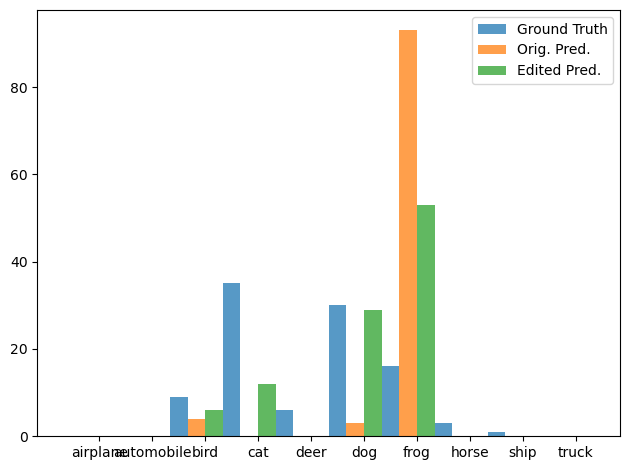

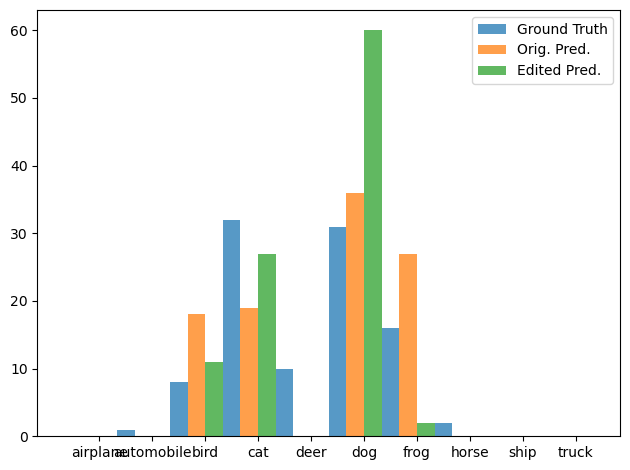

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/quickshift_masked_0/models
Finished trial 4/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/quickshift_masked_0
Starting Trial 5/37...
Current run_id: 0112_121958/dog-train-n02114712_211/slic_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/slic_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712_211/modified_images/slic_ma

100%|██████████████████████████████████████████| 274/274 [01:28<00:00,  3.08it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.056870780885219574 0.004076279234141111
L2 norm of weight change: 0.19450516998767853
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:56<00:00,  2.35it/s]


Post-edit metrics: {'TP': array([6140, 5331, 5334, 3970, 4290, 3118, 5135, 5173, 4914, 4630]), 'TN': array([60073, 61228, 59002, 59651, 60000, 61508, 62036, 61662, 61514,
       61361]), 'FPs': array([2927, 1772, 3998, 3349, 3000, 1492,  964, 1338, 1486, 1639]), 'FNs': array([ 860, 1669, 1666, 3030, 2710, 3882, 1865, 1827, 2086, 2370]), 'accuracy': 0.6862142857142857, 'per_class_accuracy': array([0.9459    , 0.95084286, 0.91908571, 0.90887143, 0.91842857,
       0.92322857, 0.95958571, 0.95478571, 0.94897143, 0.94272857]), 'per_class_accuracy_mean': 0.9372428571428572, 'precision': array([0.67718099, 0.75052795, 0.57158165, 0.54242383, 0.58847737,
       0.67635575, 0.8419413 , 0.79450161, 0.7678125 , 0.73855479]), 'precision_mean': 0.6949357737409922, 'recall': array([0.87714286, 0.76157143, 0.762     , 0.56714286, 0.61285714,
       0.44542857, 0.73357143, 0.739     , 0.702     , 0.66142857]), 'recall_mean': 0.6862142857142857, 'f1': array([0.7642995 , 0.75600936, 0.65319618, 0.55450

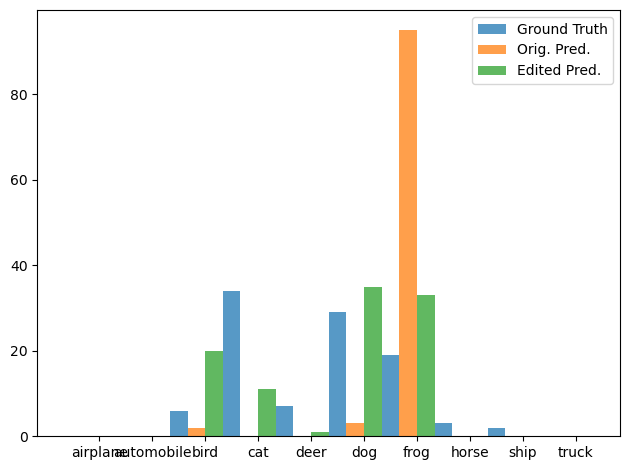

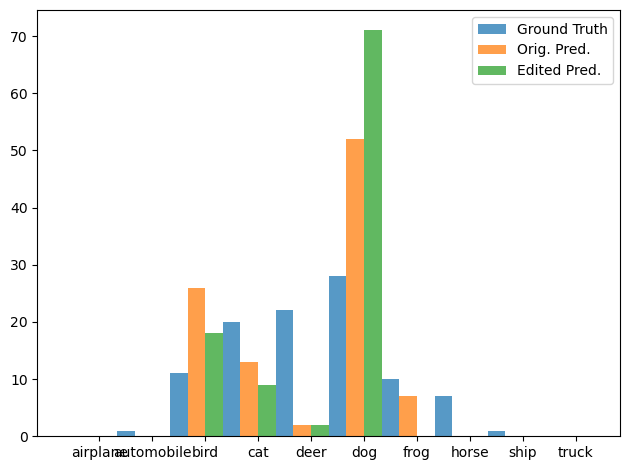

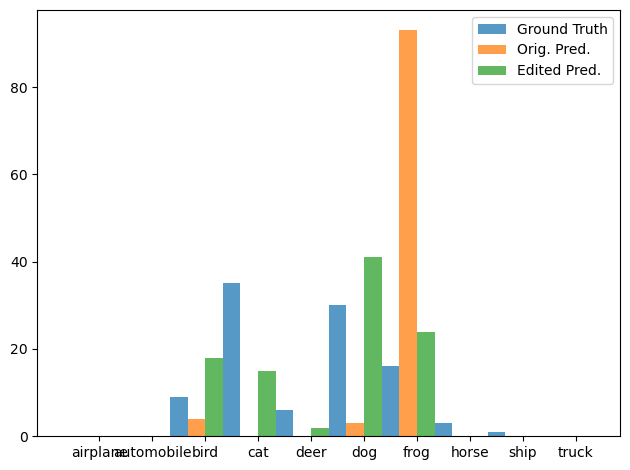

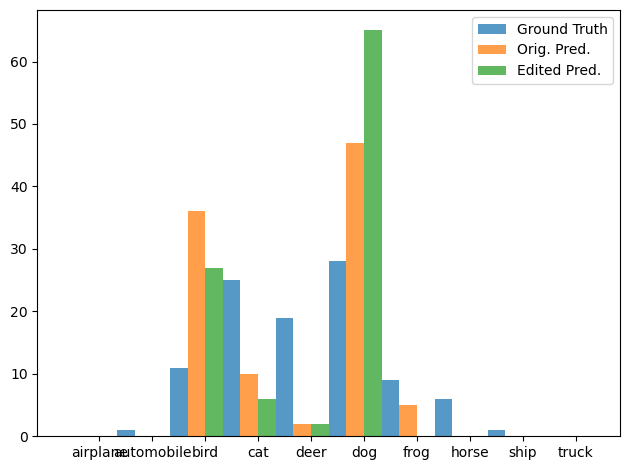

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/slic_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/slic_masked_0/models
Finished trial 5/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/slic_masked_0
Starting Trial 6/37...
Current run_id: 0112_121958/dog-train-n02114712_211/watershed_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/watershed_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114712_211.png
Value images: saved/segmentations/dog-train-n02114712_211/modified_images/watershed_maske

100%|██████████████████████████████████████████| 274/274 [02:40<00:00,  1.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07313124090433121 0.005388882476836443
L2 norm of weight change: 0.25711220502853394
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:44<00:00,  2.62it/s]


Post-edit metrics: {'TP': array([6093, 5316, 5118, 4275, 4212, 3289, 5077, 5170, 4922, 4638]), 'TN': array([60331, 61259, 59770, 58679, 60186, 61103, 62168, 61684, 61529,
       61401]), 'FPs': array([2669, 1741, 3230, 4321, 2814, 1897,  832, 1316, 1471, 1599]), 'FNs': array([ 907, 1684, 1882, 2725, 2788, 3711, 1923, 1830, 2078, 2362]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94891429, 0.95107143, 0.92697143, 0.89934286, 0.91997143,
       0.91988571, 0.96064286, 0.95505714, 0.9493    , 0.94341429]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.69538918, 0.7532946 , 0.61308098, 0.49732434, 0.59948762,
       0.63420748, 0.85919783, 0.79710145, 0.76990458, 0.74362674]), 'precision_mean': 0.696261480499339, 'recall': array([0.87042857, 0.75942857, 0.73114286, 0.61071429, 0.60171429,
       0.46985714, 0.72528571, 0.73857143, 0.70314286, 0.66257143]), 'recall_mean': 0.6872857142857143, 'f1': array([0.77312524, 0.75634915, 0.66692729, 0.548217

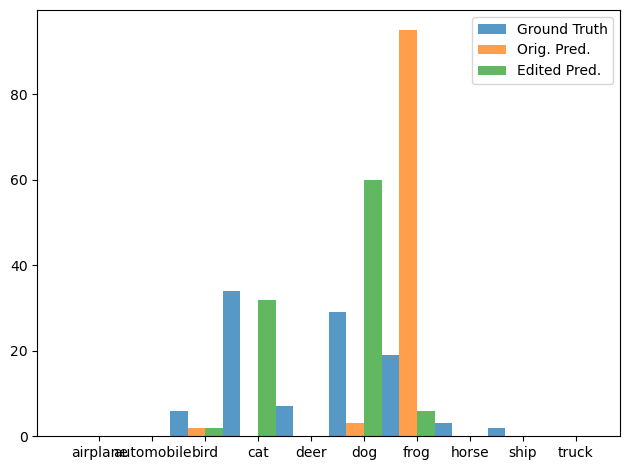

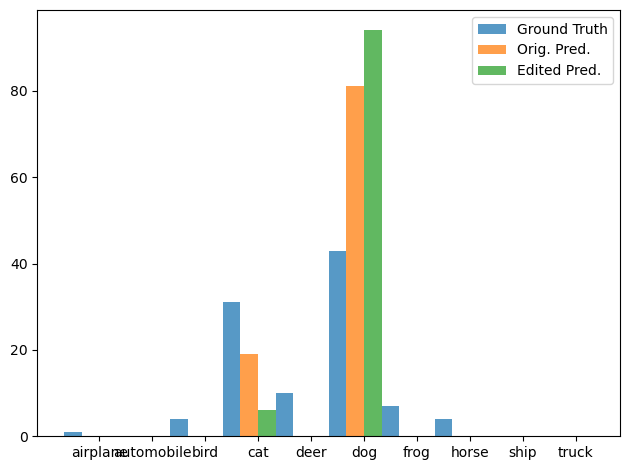

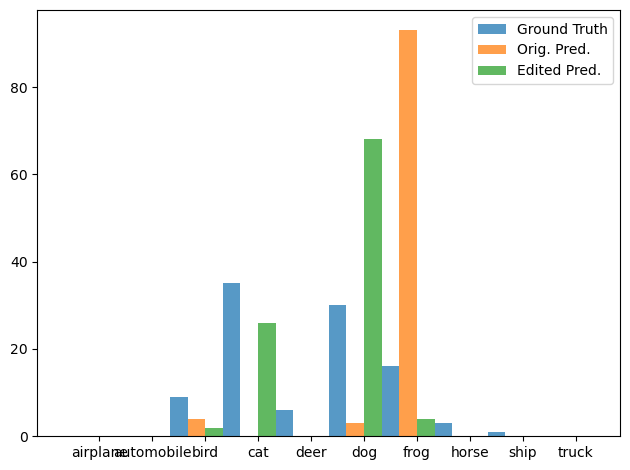

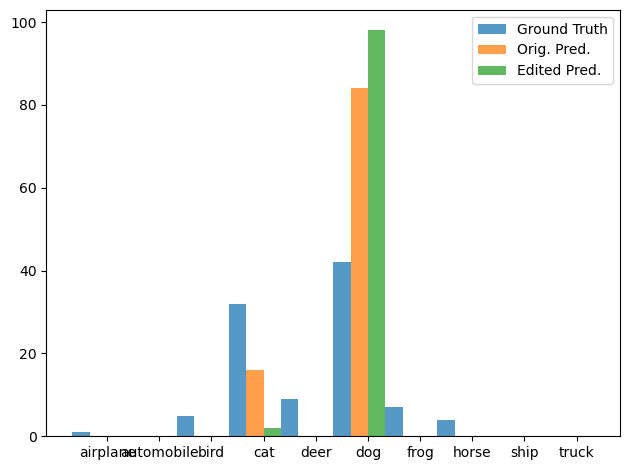

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/watershed_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/watershed_masked_1/models
Finished trial 6/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/watershed_masked_1
Starting Trial 7/37...
Current run_id: 0112_121958/dog-train-n02110341_7544/slic_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02110341_7544/slic_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02110341_7544.png
Value images: saved/segmentations/dog-train-n02110341_7544/modified_images/slic_m

100%|██████████████████████████████████████████| 274/274 [01:51<00:00,  2.46it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.14896437525749207 0.026368774473667145
L2 norm of weight change: 0.3816705048084259
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:35<00:00,  2.88it/s]


Post-edit metrics: {'TP': array([6093, 5403, 2711, 4157, 4485, 3450, 5721, 5064, 5034, 4669]), 'TN': array([60432, 61071, 62753, 58836, 59488, 58663, 61104, 61867, 61350,
       61223]), 'FPs': array([2568, 1929,  247, 4164, 3512, 4337, 1896, 1133, 1650, 1777]), 'FNs': array([ 907, 1597, 4289, 2843, 2515, 3550, 1279, 1936, 1966, 2331]), 'accuracy': 0.6683857142857142, 'per_class_accuracy': array([0.95035714, 0.94962857, 0.9352    , 0.8999    , 0.9139    ,
       0.88732857, 0.95464286, 0.95615714, 0.94834286, 0.94131429]), 'per_class_accuracy_mean': 0.933677142857143, 'precision': array([0.70349844, 0.73690671, 0.91649763, 0.49957938, 0.56083531,
       0.4430461 , 0.7510831 , 0.8171696 , 0.75314183, 0.72432516]), 'precision_mean': 0.6906083274242555, 'recall': array([0.87042857, 0.77185714, 0.38728571, 0.59385714, 0.64071429,
       0.49285714, 0.81728571, 0.72342857, 0.71914286, 0.667     ]), 'recall_mean': 0.6683857142857142, 'f1': array([0.77811123, 0.75397711, 0.54448684, 0.542653

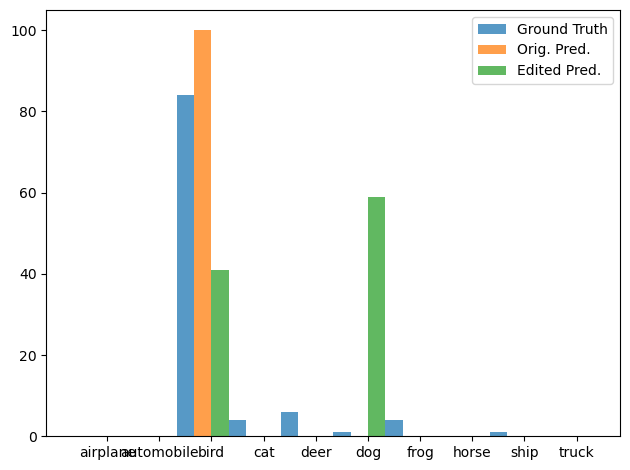

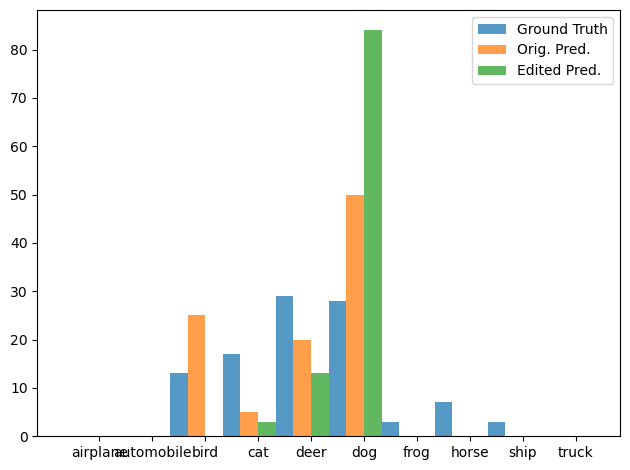

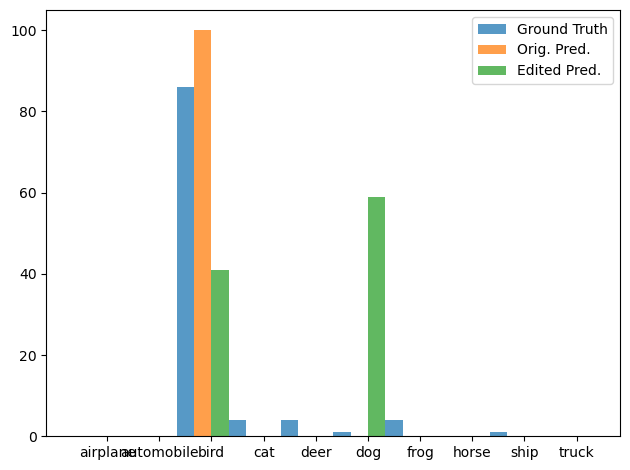

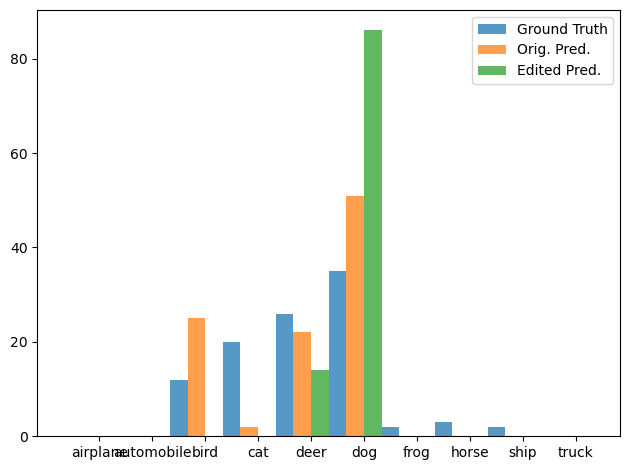

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02110341_7544/slic_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02110341_7544/slic_masked_2/models
Finished trial 7/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02110341_7544/slic_masked_2
Starting Trial 8/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/quickshift_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/quickshift_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/modified_images/quicks

100%|██████████████████████████████████████████| 274/274 [01:43<00:00,  2.64it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0031, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.018519937992095947 0.0030568335205316544
L2 norm of weight change: 0.1268027424812317
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:28<00:00,  3.11it/s]


Post-edit metrics: {'TP': array([6099, 5439, 5185, 3716, 4243, 3096, 5694, 5156, 4876, 4686]), 'TN': array([60325, 60985, 59537, 60149, 60219, 61595, 60976, 61708, 61583,
       61113]), 'FPs': array([2675, 2015, 3463, 2851, 2781, 1405, 2024, 1292, 1417, 1887]), 'FNs': array([ 901, 1561, 1815, 3284, 2757, 3904, 1306, 1844, 2124, 2314]), 'accuracy': 0.6884285714285714, 'per_class_accuracy': array([0.94891429, 0.94891429, 0.9246    , 0.91235714, 0.92088571,
       0.92415714, 0.95242857, 0.9552    , 0.94941429, 0.93998571]), 'per_class_accuracy_mean': 0.9376857142857145, 'precision': array([0.69512195, 0.72967534, 0.59956059, 0.5658596 , 0.60407175,
       0.68784715, 0.7377559 , 0.79962779, 0.77482918, 0.71291648]), 'precision_mean': 0.6907265724104608, 'recall': array([0.87128571, 0.777     , 0.74071429, 0.53085714, 0.60614286,
       0.44228571, 0.81342857, 0.73657143, 0.69657143, 0.66942857]), 'recall_mean': 0.6884285714285714, 'f1': array([0.77329783, 0.75259444, 0.6627045 , 0.54779

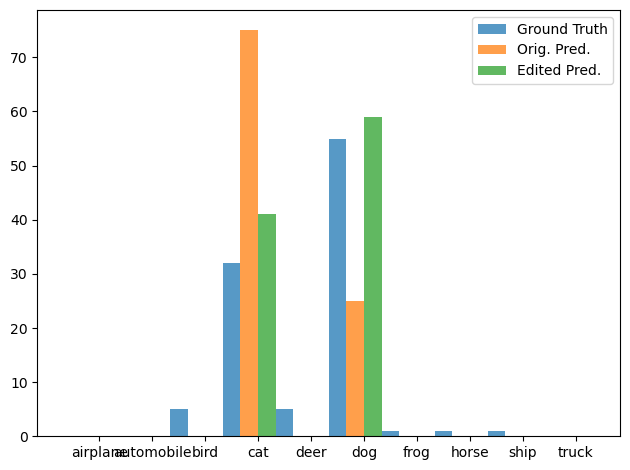

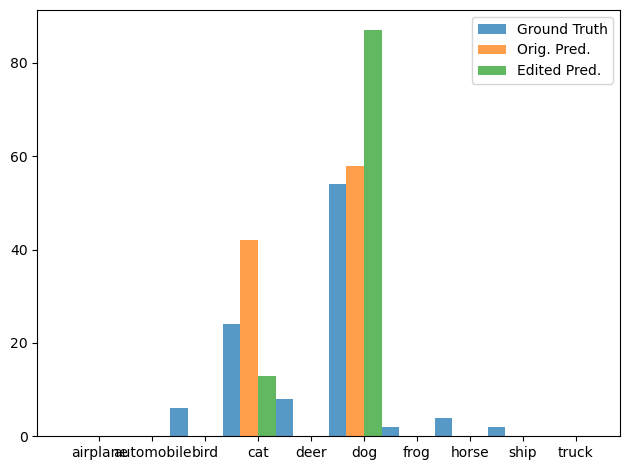

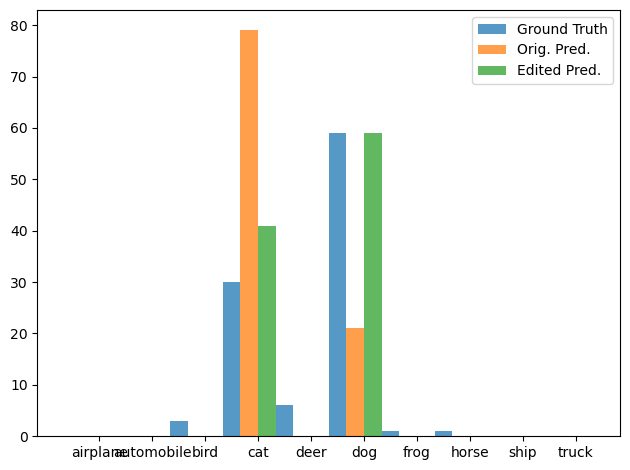

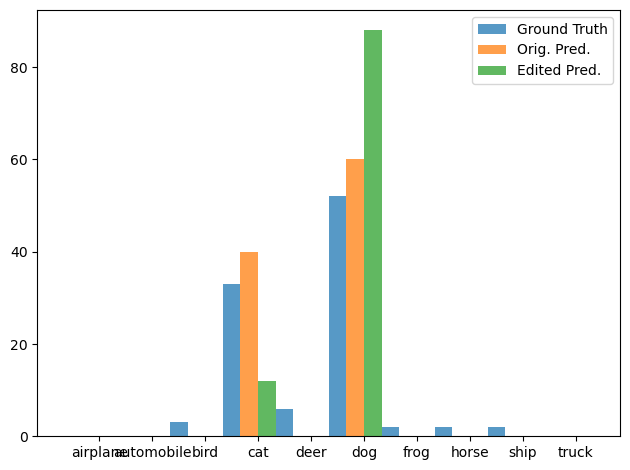

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/quickshift_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/quickshift_masked_3/models
Finished trial 8/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/quickshift_masked_3
Starting Trial 9/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/slic_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/modified_ima

100%|██████████████████████████████████████████| 274/274 [01:23<00:00,  3.28it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.048103101551532745 0.004489652346819639
L2 norm of weight change: 0.22516930103302002
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:44<00:00,  2.63it/s]


Post-edit metrics: {'TP': array([6089, 5507, 5546, 3361, 4179, 3206, 5627, 5106, 4727, 4414]), 'TN': array([60307, 60908, 57854, 60729, 60307, 61486, 60997, 61831, 61721,
       61622]), 'FPs': array([2693, 2092, 5146, 2271, 2693, 1514, 2003, 1169, 1279, 1378]), 'FNs': array([ 911, 1493, 1454, 3639, 2821, 3794, 1373, 1894, 2273, 2586]), 'accuracy': 0.6823142857142858, 'per_class_accuracy': array([0.94851429, 0.94878571, 0.90571429, 0.91557143, 0.92122857,
       0.92417143, 0.95177143, 0.95624286, 0.94925714, 0.94337143]), 'per_class_accuracy_mean': 0.936462857142857, 'precision': array([0.69335003, 0.72470062, 0.51870557, 0.59676847, 0.60811991,
       0.67923729, 0.73748362, 0.81370518, 0.78704629, 0.76208564]), 'precision_mean': 0.6921202606825887, 'recall': array([0.86985714, 0.78671429, 0.79228571, 0.48014286, 0.597     ,
       0.458     , 0.80385714, 0.72942857, 0.67528571, 0.63057143]), 'recall_mean': 0.6823142857142857, 'f1': array([0.77163858, 0.75443524, 0.62695003, 0.532140

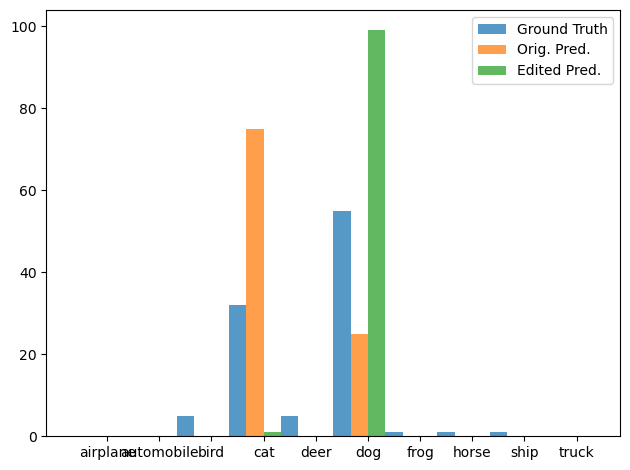

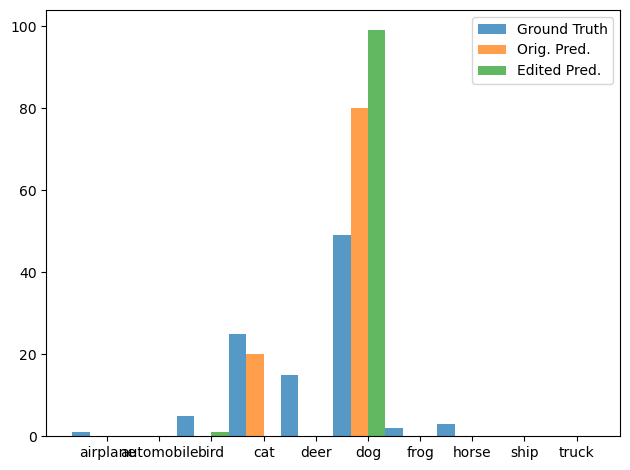

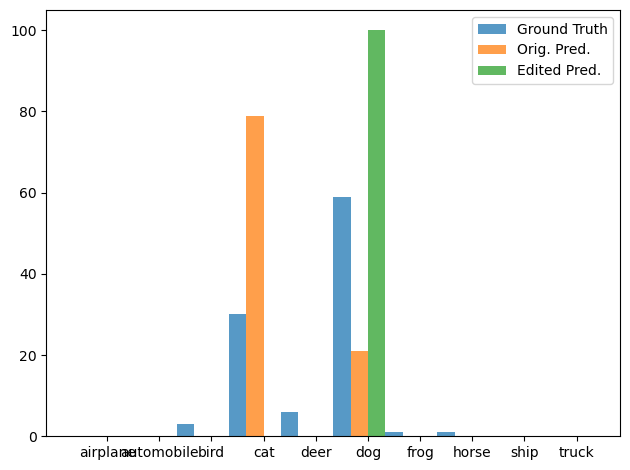

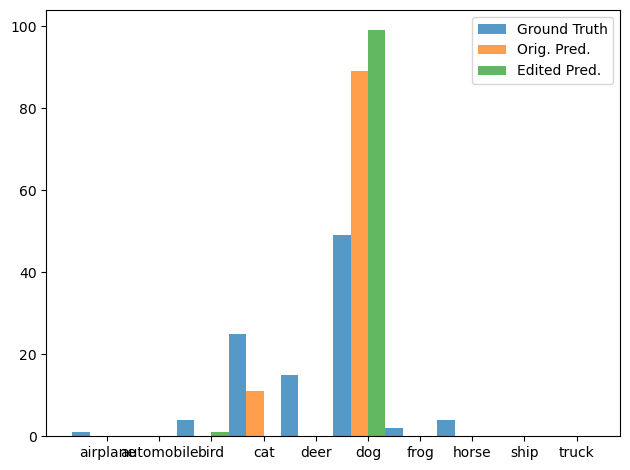

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_2/models
Finished trial 9/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_2
Starting Trial 10/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/slic_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/modified_images/slic_ga

100%|██████████████████████████████████████████| 274/274 [02:34<00:00,  1.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0034, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.011164937168359756 0.003427250310778618
L2 norm of weight change: 0.162669837474823
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:15<00:00,  2.03it/s]


Post-edit metrics: {'TP': array([6101, 5408, 5262, 3820, 4249, 3144, 5613, 5118, 4852, 4589]), 'TN': array([60285, 61102, 59201, 59897, 60152, 61514, 61178, 61800, 61614,
       61413]), 'FPs': array([2715, 1898, 3799, 3103, 2848, 1486, 1822, 1200, 1386, 1587]), 'FNs': array([ 899, 1592, 1738, 3180, 2751, 3856, 1387, 1882, 2148, 2411]), 'accuracy': 0.6879428571428572, 'per_class_accuracy': array([0.94837143, 0.95014286, 0.9209    , 0.91024286, 0.92001429,
       0.92368571, 0.95415714, 0.95597143, 0.94951429, 0.94288571]), 'per_class_accuracy_mean': 0.9375885714285713, 'precision': array([0.69203721, 0.74021352, 0.5807306 , 0.55178391, 0.59870368,
       0.67904968, 0.75494284, 0.81006648, 0.7778134 , 0.74303756]), 'precision_mean': 0.6928378875405765, 'recall': array([0.87157143, 0.77257143, 0.75171429, 0.54571429, 0.607     ,
       0.44914286, 0.80185714, 0.73114286, 0.69314286, 0.65557143]), 'recall_mean': 0.6879428571428571, 'f1': array([0.77149722, 0.75604641, 0.65525185, 0.54873

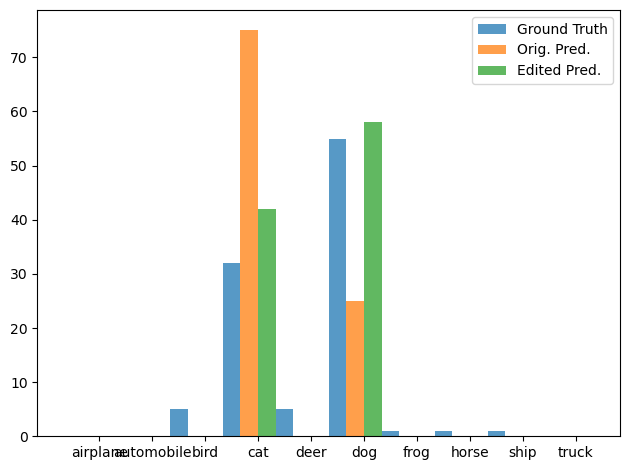

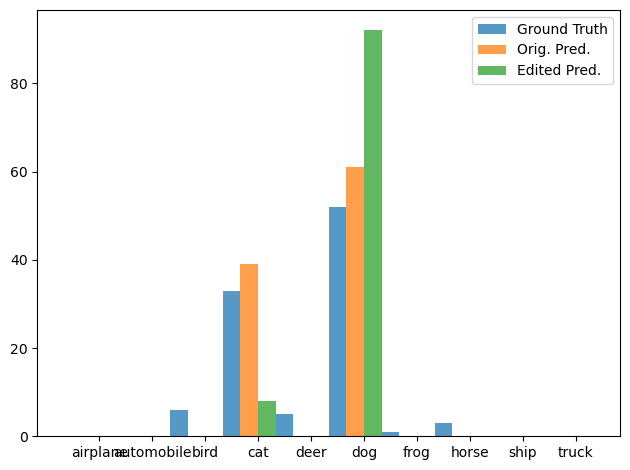

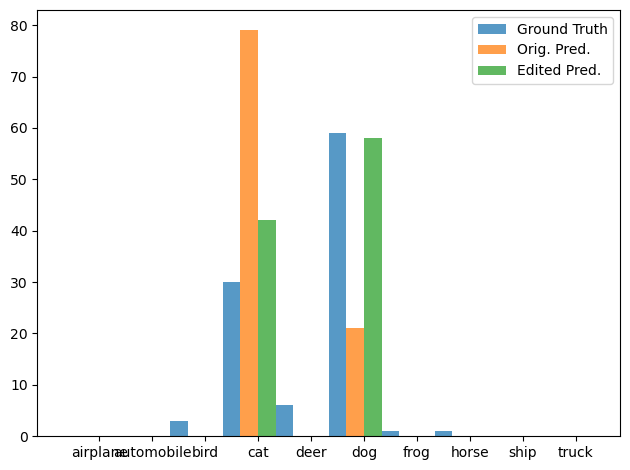

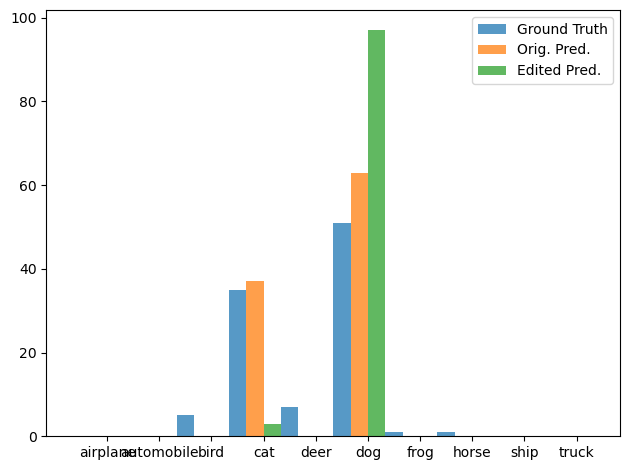

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_4/models
Finished trial 10/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/slic_gaussian_4
Starting Trial 11/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/modified_ima

100%|██████████████████████████████████████████| 274/274 [01:57<00:00,  2.33it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11217455565929413 0.005566644016653299
L2 norm of weight change: 0.3938358426094055
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:10<00:00,  2.10it/s]


Post-edit metrics: {'TP': array([6025, 5589, 5789, 2337, 4148, 2858, 5614, 5188, 4803, 4487]), 'TN': array([60437, 60619, 55739, 62272, 60333, 61997, 60930, 61602, 61594,
       61315]), 'FPs': array([2563, 2381, 7261,  728, 2667, 1003, 2070, 1398, 1406, 1685]), 'FNs': array([ 975, 1411, 1211, 4663, 2852, 4142, 1386, 1812, 2197, 2513]), 'accuracy': 0.6691142857142857, 'per_class_accuracy': array([0.94945714, 0.94582857, 0.87897143, 0.92298571, 0.92115714,
       0.9265    , 0.95062857, 0.95414286, 0.94852857, 0.94002857]), 'per_class_accuracy_mean': 0.9338228571428571, 'precision': array([0.70156032, 0.70125471, 0.44360153, 0.76247961, 0.60865737,
       0.74022274, 0.73060906, 0.78773155, 0.77355452, 0.72699287]), 'precision_mean': 0.6976664274803948, 'recall': array([0.86071429, 0.79842857, 0.827     , 0.33385714, 0.59257143,
       0.40828571, 0.802     , 0.74114286, 0.68614286, 0.641     ]), 'recall_mean': 0.6691142857142858, 'f1': array([0.77303054, 0.74669339, 0.57745636, 0.46438

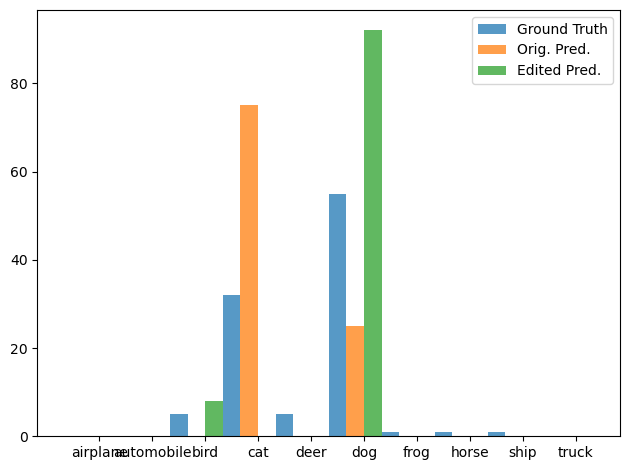

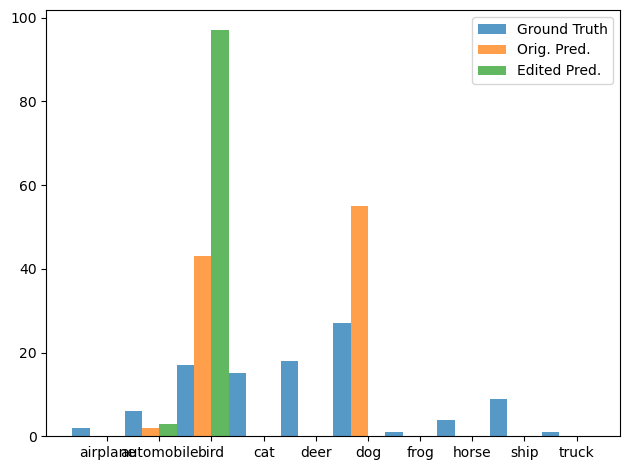

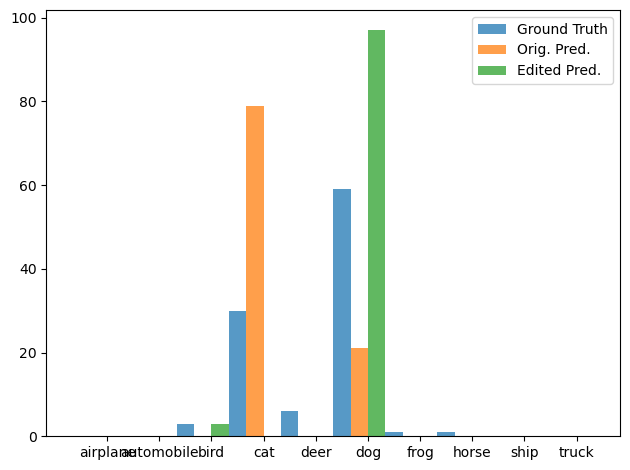

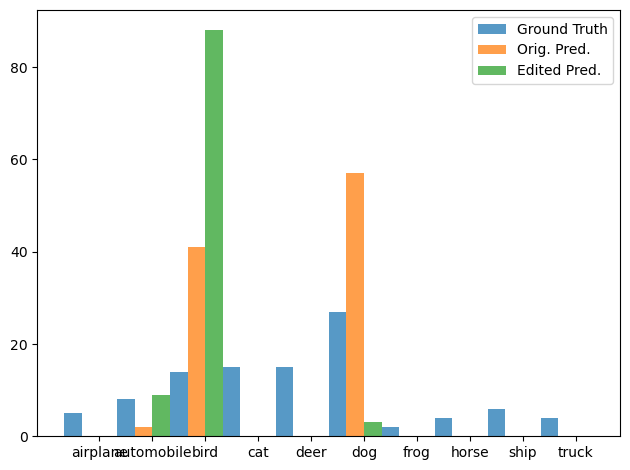

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_0/models
Finished trial 11/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_0
Starting Trial 12/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/watershed_gaussian_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_87

100%|██████████████████████████████████████████| 274/274 [01:42<00:00,  2.67it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.010202142409980297 0.0035550114698708057
L2 norm of weight change: 0.1677454710006714
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:02<00:00,  2.24it/s]


Post-edit metrics: {'TP': array([6100, 5403, 5259, 3845, 4236, 3137, 5618, 5101, 4856, 4593]), 'TN': array([60277, 61111, 59212, 59829, 60186, 61519, 61173, 61825, 61610,
       61406]), 'FPs': array([2723, 1889, 3788, 3171, 2814, 1481, 1827, 1175, 1390, 1594]), 'FNs': array([ 900, 1597, 1741, 3155, 2764, 3863, 1382, 1899, 2144, 2407]), 'accuracy': 0.6878285714285715, 'per_class_accuracy': array([0.94824286, 0.9502    , 0.92101429, 0.90962857, 0.92031429,
       0.92365714, 0.95415714, 0.95608571, 0.94951429, 0.94284286]), 'per_class_accuracy_mean': 0.9375657142857143, 'precision': array([0.69137482, 0.74094899, 0.58129767, 0.54803307, 0.60085106,
       0.6792984 , 0.7546004 , 0.81277884, 0.77745757, 0.74236302]), 'precision_mean': 0.6929003832486984, 'recall': array([0.87142857, 0.77185714, 0.75128571, 0.54928571, 0.60514286,
       0.44814286, 0.80257143, 0.72871429, 0.69371429, 0.65614286]), 'recall_mean': 0.6878285714285715, 'f1': array([0.77102951, 0.75608732, 0.65544962, 0.54865

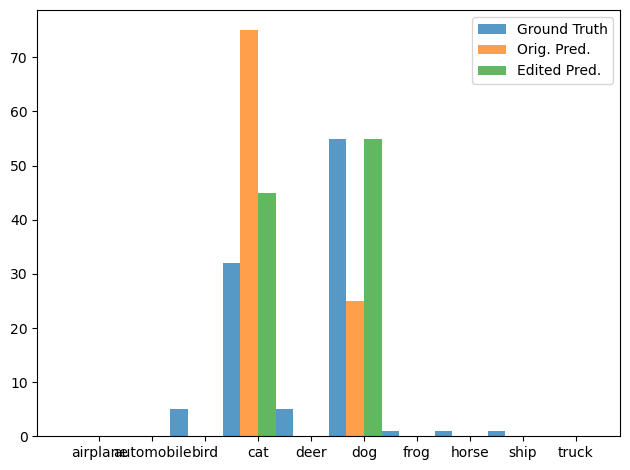

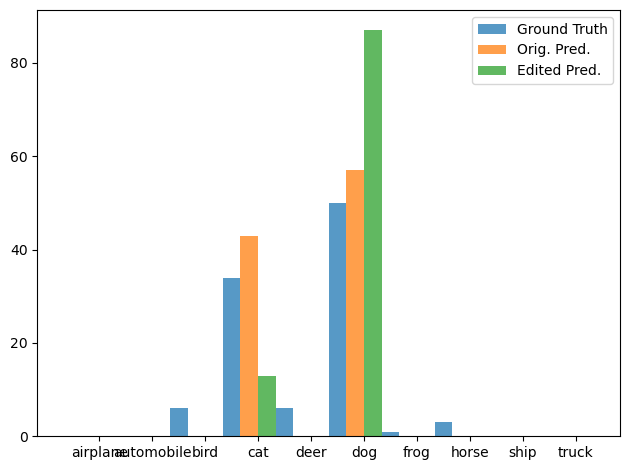

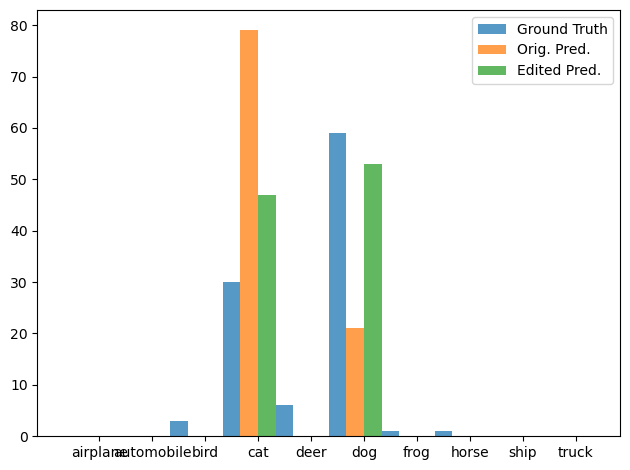

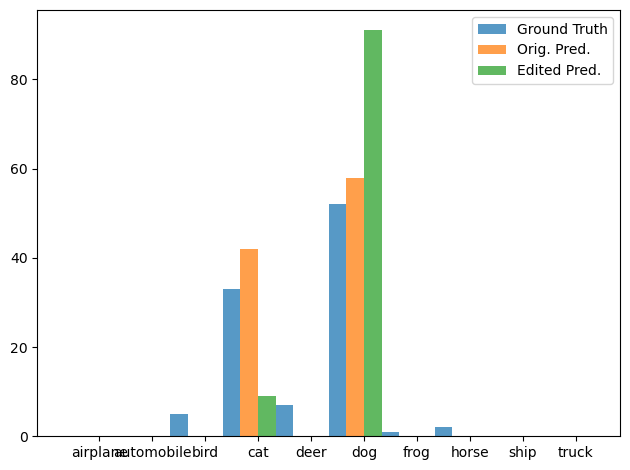

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_3/models
Finished trial 12/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_gaussian_3
Starting Trial 13/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/m

100%|██████████████████████████████████████████| 274/274 [01:35<00:00,  2.87it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07673824578523636 0.005339703988283873
L2 norm of weight change: 0.2954769432544708
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [07:33<00:00,  1.66s/it]


Post-edit metrics: {'TP': array([6123, 5535, 5679, 3028, 4200, 2978, 5600, 5257, 4522, 4357]), 'TN': array([60124, 60851, 56791, 61349, 60198, 61862, 61023, 61474, 61934,
       61673]), 'FPs': array([2876, 2149, 6209, 1651, 2802, 1138, 1977, 1526, 1066, 1327]), 'FNs': array([ 877, 1465, 1321, 3972, 2800, 4022, 1400, 1743, 2478, 2643]), 'accuracy': 0.6754142857142857, 'per_class_accuracy': array([0.94638571, 0.94837143, 0.89242857, 0.91967143, 0.91997143,
       0.92628571, 0.95175714, 0.9533    , 0.94937143, 0.94328571]), 'per_class_accuracy_mean': 0.9350828571428572, 'precision': array([0.68040893, 0.72032795, 0.47770861, 0.64714683, 0.59982862,
       0.72351798, 0.73907879, 0.7750258 , 0.80923407, 0.76653765]), 'precision_mean': 0.6938815240931848, 'recall': array([0.87471429, 0.79071429, 0.81128571, 0.43257143, 0.6       ,
       0.42542857, 0.8       , 0.751     , 0.646     , 0.62242857]), 'recall_mean': 0.6754142857142857, 'f1': array([0.76542284, 0.75388178, 0.60133418, 0.51853

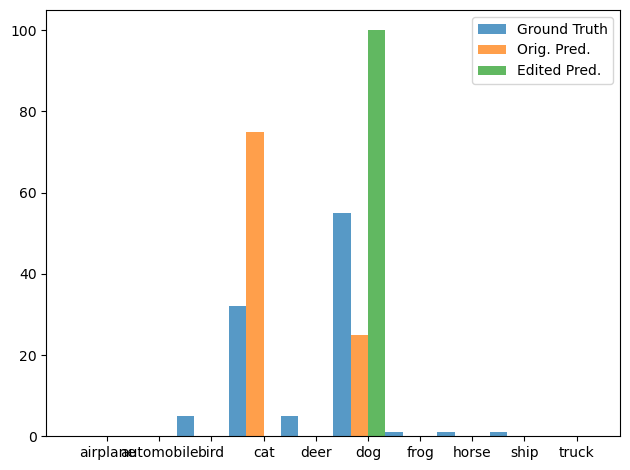

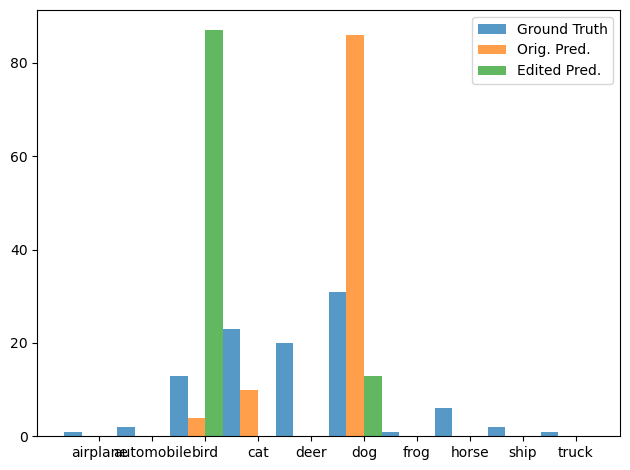

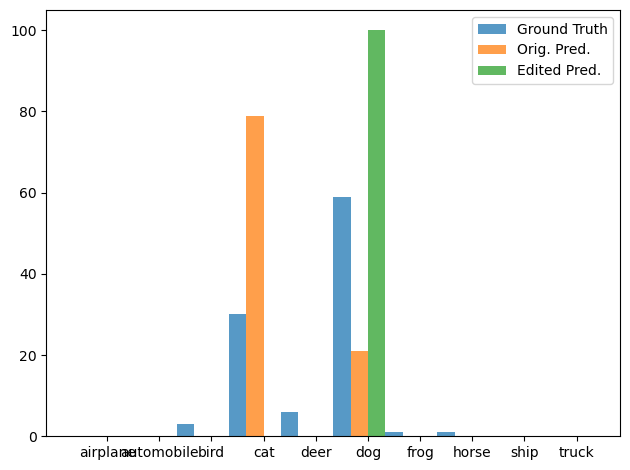

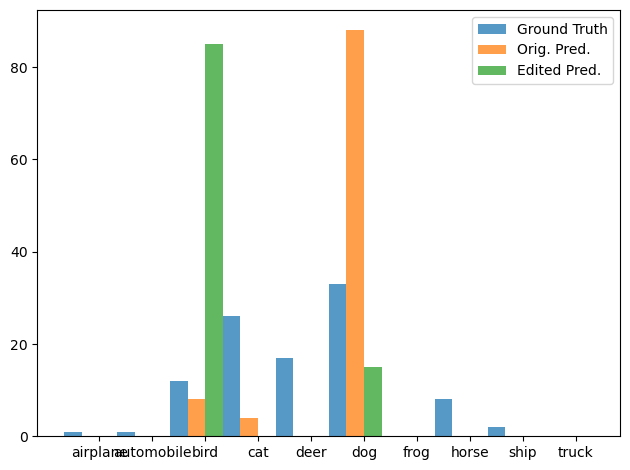

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_2/models
Finished trial 13/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_2
Starting Trial 14/37...
Current run_id: 0112_121958/dog-train-n02089232_8735/watershed_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02089232_8735.png
Value images: saved/segmentations/dog-train-n02089232_8735/modifie

100%|██████████████████████████████████████████| 274/274 [01:58<00:00,  2.32it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.050151895731687546 0.004375938326120377
L2 norm of weight change: 0.21728837490081787
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [08:47<00:00,  1.92s/it]


Post-edit metrics: {'TP': array([6061, 5489, 5524, 3345, 4248, 3289, 5551, 5111, 4859, 4422]), 'TN': array([60360, 60965, 58008, 60814, 60133, 61360, 61231, 61831, 61571,
       61626]), 'FPs': array([2640, 2035, 4992, 2186, 2867, 1640, 1769, 1169, 1429, 1374]), 'FNs': array([ 939, 1511, 1476, 3655, 2752, 3711, 1449, 1889, 2141, 2578]), 'accuracy': 0.6842714285714285, 'per_class_accuracy': array([0.94887143, 0.94934286, 0.9076    , 0.91655714, 0.91972857,
       0.92355714, 0.95402857, 0.95631429, 0.949     , 0.94354286]), 'per_class_accuracy_mean': 0.9368542857142858, 'precision': array([0.6965866 , 0.72953216, 0.52529479, 0.6047731 , 0.59704849,
       0.66727531, 0.75833333, 0.8138535 , 0.77274173, 0.76293996]), 'precision_mean': 0.6928378972857389, 'recall': array([0.86585714, 0.78414286, 0.78914286, 0.47785714, 0.60685714,
       0.46985714, 0.793     , 0.73014286, 0.69414286, 0.63171429]), 'recall_mean': 0.6842714285714286, 'f1': array([0.77205274, 0.75585238, 0.63073761, 0.53387

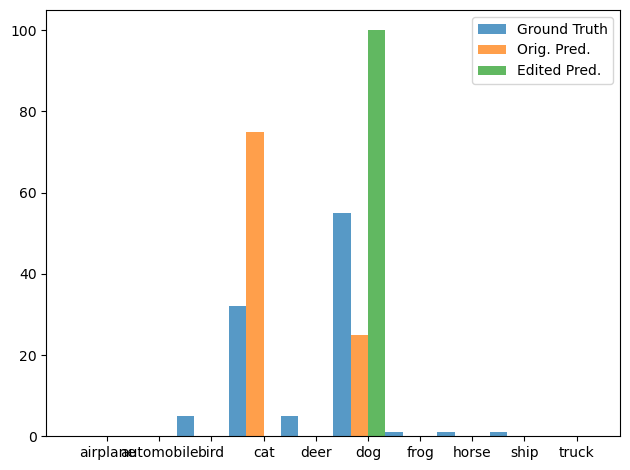

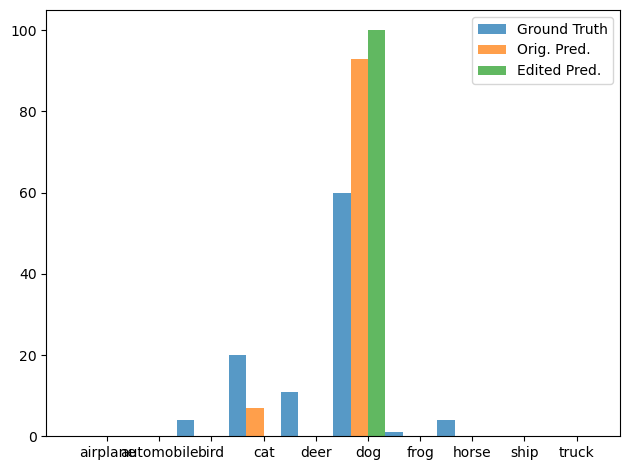

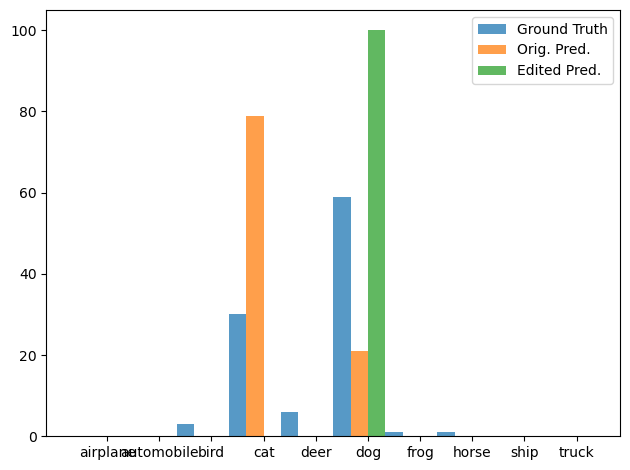

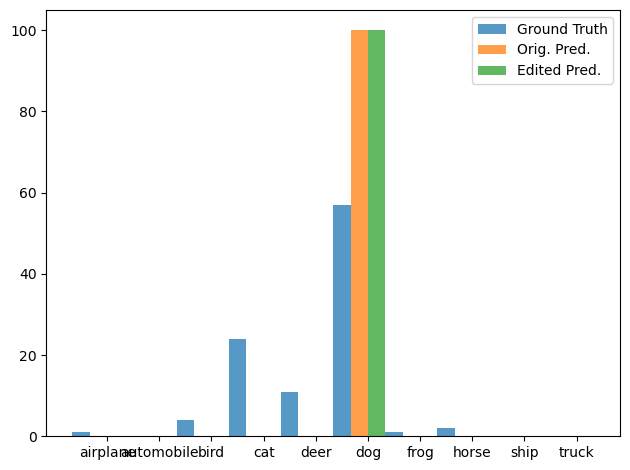

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_3/models
Finished trial 14/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02089232_8735/watershed_masked_3
Starting Trial 15/37...
Current run_id: 0112_121958/dog-train-n02087394_9410/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_9410/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02087394_9410.png
Value images: saved/segmentations/dog-train-n02087394_9410/modif

100%|██████████████████████████████████████████| 274/274 [02:27<00:00,  1.86it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0406, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.16940028965473175 0.040552809834480286
L2 norm of weight change: 0.4085729420185089
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:08<00:00,  2.13it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6110, 5494, 5433, 3926,    0, 3860, 5529, 5225, 4730, 4624]), 'TN': array([60252, 60885, 58553, 59646, 63000, 56608, 61349, 61643, 61755,
       61240]), 'FPs': array([2748, 2115, 4447, 3354,    0, 6392, 1651, 1357, 1245, 1760]), 'FNs': array([ 890, 1506, 1567, 3074, 7000, 3140, 1471, 1775, 2270, 2376]), 'accuracy': 0.6418714285714285, 'per_class_accuracy': array([0.94802857, 0.94827143, 0.91408571, 0.90817143, 0.9       ,
       0.86382857, 0.9554    , 0.95525714, 0.94978571, 0.94091429]), 'per_class_accuracy_mean': 0.9283742857142856, 'precision': array([0.68977196, 0.72203969, 0.54989879, 0.53928571, 0.        ,
       0.3765119 , 0.77005571, 0.79383166, 0.7916318 , 0.72431078]), 'precision_mean': 0.5957337995742062, 'recall': array([0.87285714, 0.78485714, 0.77614286, 0.56085714, 0.        ,
       0.55142857, 0.78985714, 0.74642857, 0.67571429, 0.66057143]), 'recall_mean': 0.6418714285714285, 'f1': array([0.77058898, 0.75213909, 0.64372038, 0.54985

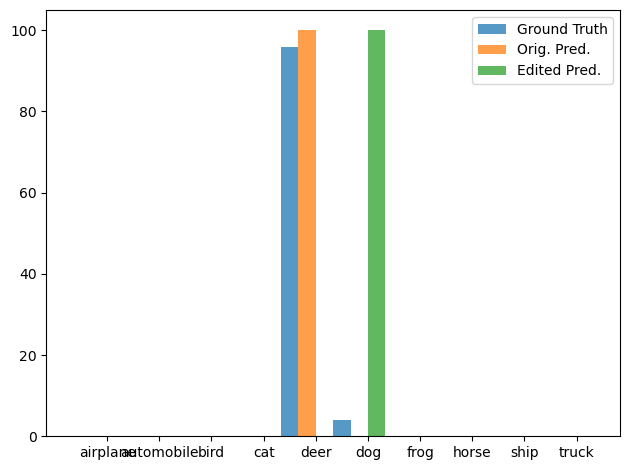

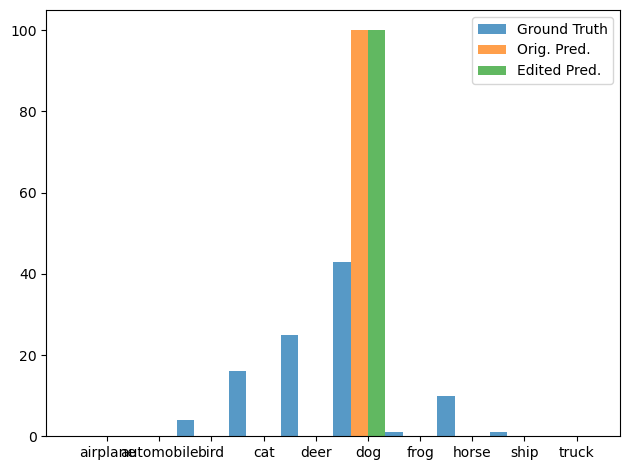

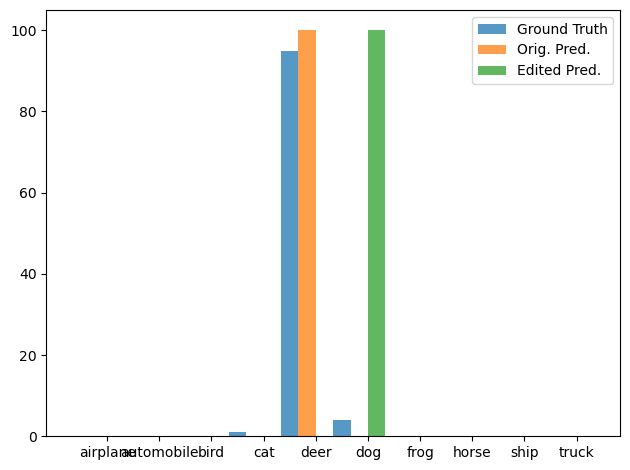

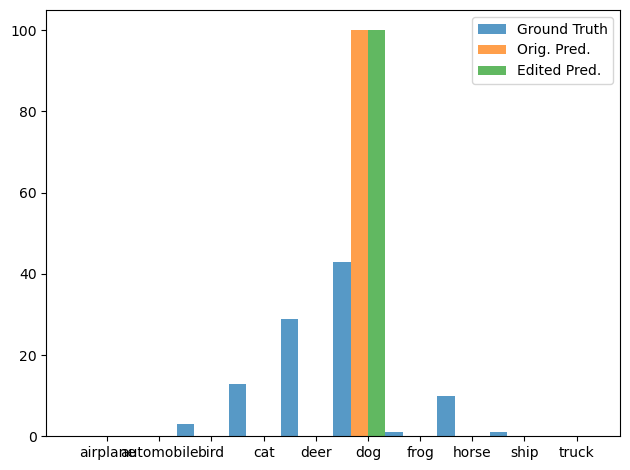

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_9410/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_9410/quickshift_masked_1/models
Finished trial 15/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_9410/quickshift_masked_1
Starting Trial 16/37...
Current run_id: 0112_121958/dog-train-n02103841_5889/felzenszwalb_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02103841_5889/felzenszwalb_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02103841_5889.png
Value images: saved/segmentations/dog-train-n02103841_588

100%|██████████████████████████████████████████| 274/274 [02:27<00:00,  1.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11008674651384354 0.006267082877457142
L2 norm of weight change: 0.3520607352256775
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:28<00:00,  1.84it/s]


Post-edit metrics: {'TP': array([6006, 5521, 3397, 3829, 4240, 3859, 5708, 5199, 4900, 4615]), 'TN': array([60837, 60839, 62464, 59932, 60162, 57461, 61094, 61636, 61565,
       61284]), 'FPs': array([2163, 2161,  536, 3068, 2838, 5539, 1906, 1364, 1435, 1716]), 'FNs': array([ 994, 1479, 3603, 3171, 2760, 3141, 1292, 1801, 2100, 2385]), 'accuracy': 0.6753428571428571, 'per_class_accuracy': array([0.9549    , 0.948     , 0.94087143, 0.91087143, 0.92002857,
       0.876     , 0.95431429, 0.95478571, 0.9495    , 0.94141429]), 'per_class_accuracy_mean': 0.9350685714285714, 'precision': array([0.73521851, 0.71869305, 0.86371726, 0.55516891, 0.59903928,
       0.41061928, 0.74967166, 0.79216822, 0.77348066, 0.72895277]), 'precision_mean': 0.6926729601493438, 'recall': array([0.858     , 0.78871429, 0.48528571, 0.547     , 0.60571429,
       0.55128571, 0.81542857, 0.74271429, 0.7       , 0.65928571]), 'recall_mean': 0.6753428571428571, 'f1': array([0.79187817, 0.75207737, 0.62142138, 0.55105

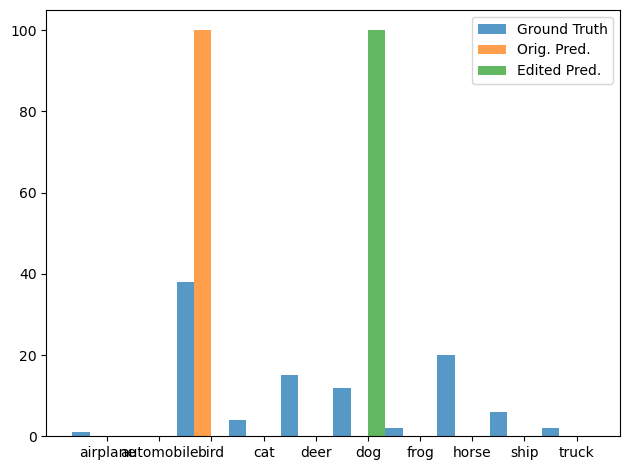

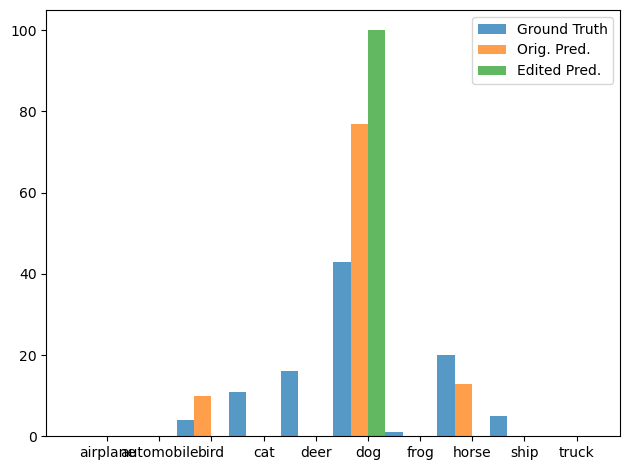

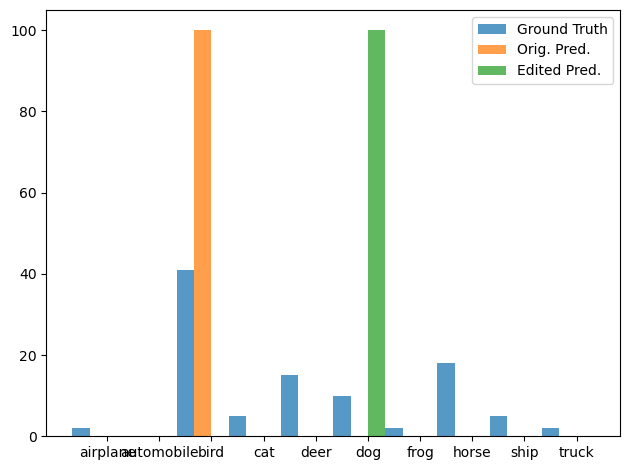

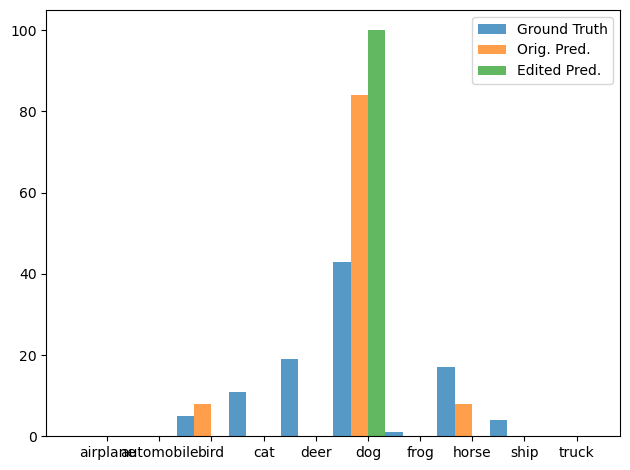

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02103841_5889/felzenszwalb_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02103841_5889/felzenszwalb_masked_2/models
Finished trial 16/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02103841_5889/felzenszwalb_masked_2
Starting Trial 17/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/felzenszwalb_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-

100%|██████████████████████████████████████████| 274/274 [02:26<00:00,  1.87it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.04233130067586899 0.004561626352369785
L2 norm of weight change: 0.18646010756492615
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:07<00:00,  2.15it/s]


Post-edit metrics: {'TP': array([6098, 5404, 5177, 4027, 4095, 3229, 5632, 4925, 4928, 4601]), 'TN': array([60287, 61087, 59547, 59293, 60569, 61271, 61134, 62087, 61487,
       61354]), 'FPs': array([2713, 1913, 3453, 3707, 2431, 1729, 1866,  913, 1513, 1646]), 'FNs': array([ 902, 1596, 1823, 2973, 2905, 3771, 1368, 2075, 2072, 2399]), 'accuracy': 0.6873714285714285, 'per_class_accuracy': array([0.94835714, 0.94987143, 0.92462857, 0.90457143, 0.92377143,
       0.92142857, 0.9538    , 0.95731429, 0.94878571, 0.94221429]), 'per_class_accuracy_mean': 0.9374742857142857, 'precision': array([0.69208943, 0.73855405, 0.59988413, 0.52068787, 0.62749004,
       0.65127067, 0.75113364, 0.84361083, 0.76509859, 0.73651353]), 'precision_mean': 0.692633277117907, 'recall': array([0.87114286, 0.772     , 0.73957143, 0.57528571, 0.585     ,
       0.46128571, 0.80457143, 0.70357143, 0.704     , 0.65728571]), 'recall_mean': 0.6873714285714285, 'f1': array([0.77136171, 0.75490675, 0.66244402, 0.546626

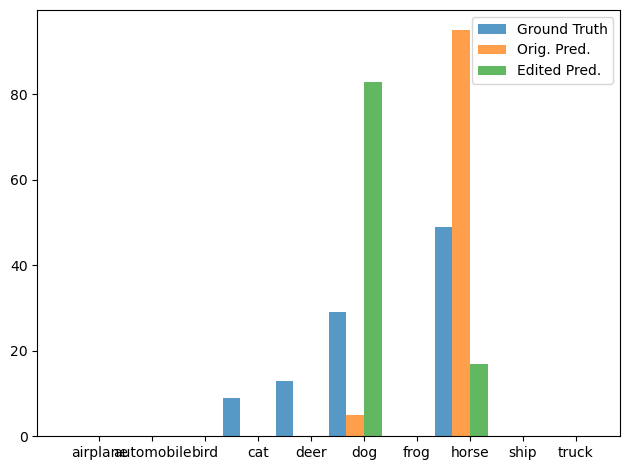

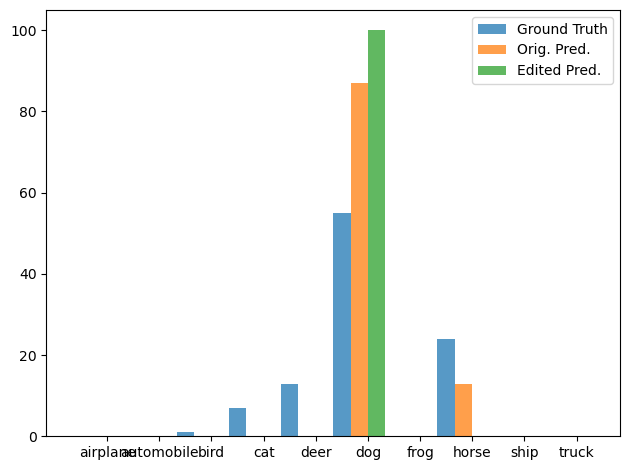

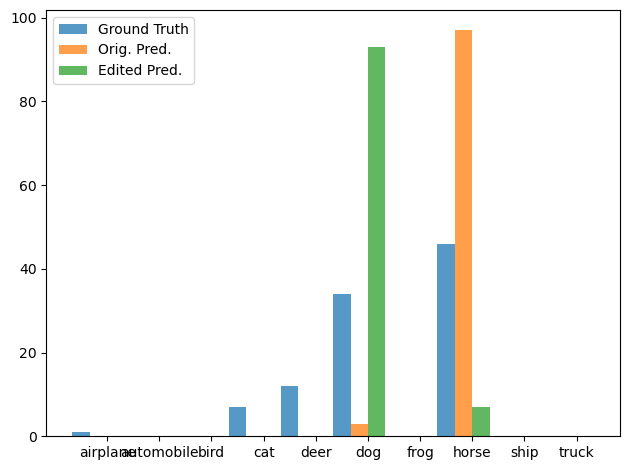

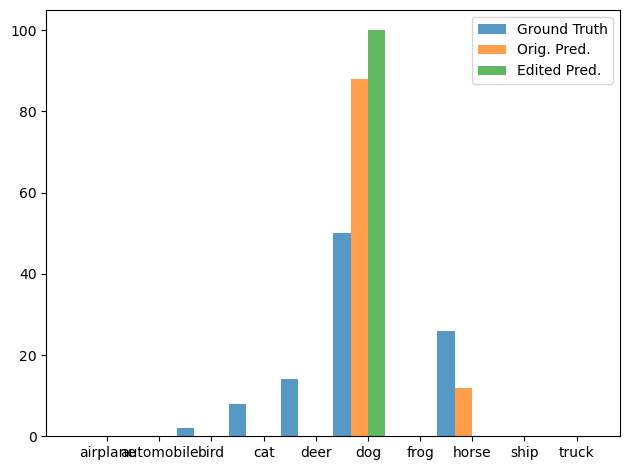

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_gaussian_4/models
Finished trial 17/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_gaussian_4
Starting Trial 18/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-t

100%|██████████████████████████████████████████| 274/274 [02:20<00:00,  1.96it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.0481865368783474 0.0035069144796580076
L2 norm of weight change: 0.25836536288261414
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:32<00:00,  1.80it/s]


Post-edit metrics: {'TP': array([6051, 5556, 5297, 3738, 3905, 3584, 5608, 5088, 4885, 4485]), 'TN': array([60492, 60788, 59145, 60096, 60916, 60658, 61230, 61848, 61543,
       61481]), 'FPs': array([2508, 2212, 3855, 2904, 2084, 2342, 1770, 1152, 1457, 1519]), 'FNs': array([ 949, 1444, 1703, 3262, 3095, 3416, 1392, 1912, 2115, 2515]), 'accuracy': 0.6885285714285714, 'per_class_accuracy': array([0.95061429, 0.94777143, 0.9206    , 0.91191429, 0.92601429,
       0.91774286, 0.95482857, 0.95622857, 0.94897143, 0.94237143]), 'per_class_accuracy_mean': 0.9377057142857144, 'precision': array([0.70697511, 0.71524202, 0.57878059, 0.56278229, 0.65202872,
       0.60479244, 0.76009759, 0.81538462, 0.77026175, 0.747002  ]), 'precision_mean': 0.6913347129318398, 'recall': array([0.86442857, 0.79371429, 0.75671429, 0.534     , 0.55785714,
       0.512     , 0.80114286, 0.72685714, 0.69785714, 0.64071429]), 'recall_mean': 0.6885285714285715, 'f1': array([0.77781348, 0.7524377 , 0.65589401, 0.54801

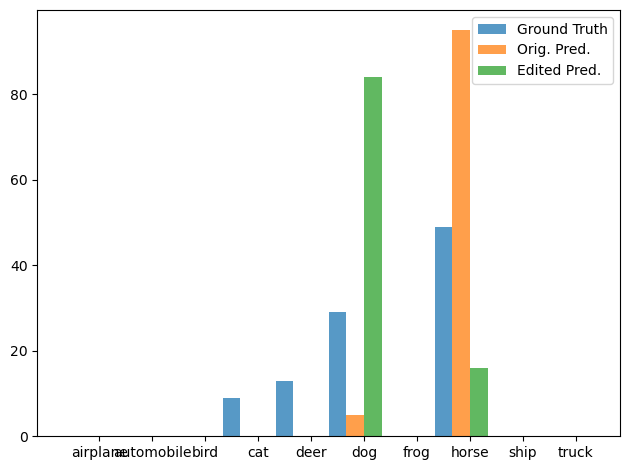

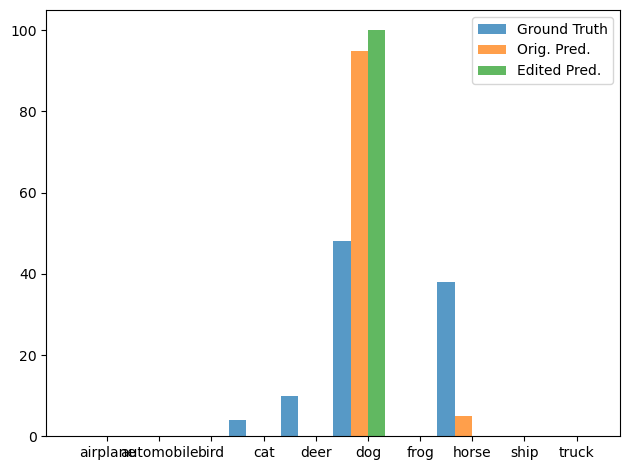

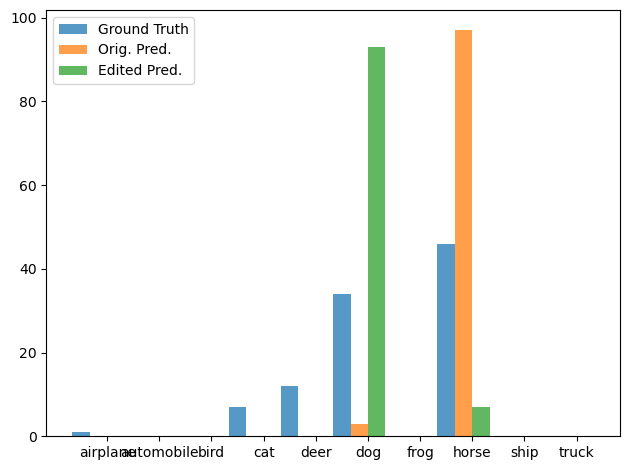

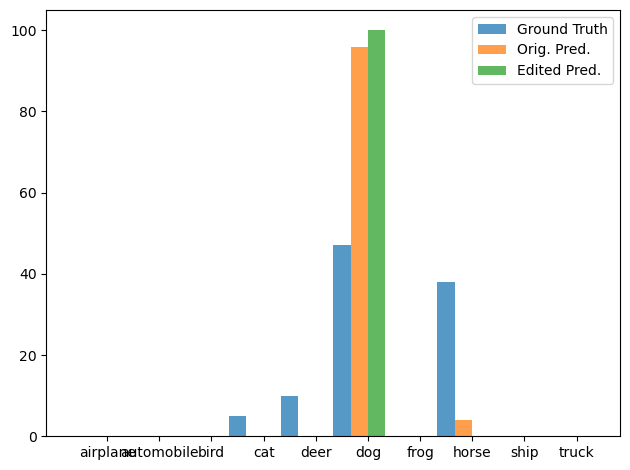

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_0/models
Finished trial 18/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_0
Starting Trial 19/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n

100%|██████████████████████████████████████████| 274/274 [02:36<00:00,  1.75it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09842541813850403 0.0063495151698589325
L2 norm of weight change: 0.35931894183158875
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:31<00:00,  1.81it/s]


Post-edit metrics: {'TP': array([5983, 5364, 4997, 4228, 4004, 3594, 5681, 3313, 5211, 4461]), 'TN': array([60793, 61184, 60110, 58323, 60786, 59190, 61001, 62851, 60974,
       61624]), 'FPs': array([2207, 1816, 2890, 4677, 2214, 3810, 1999,  149, 2026, 1376]), 'FNs': array([1017, 1636, 2003, 2772, 2996, 3406, 1319, 3687, 1789, 2539]), 'accuracy': 0.6690857142857143, 'per_class_accuracy': array([0.95394286, 0.95068571, 0.9301    , 0.89358571, 0.92557143,
       0.89691429, 0.9526    , 0.9452    , 0.9455    , 0.94407143]), 'per_class_accuracy_mean': 0.933817142857143, 'precision': array([0.73052503, 0.74707521, 0.63357424, 0.47478944, 0.64393696,
       0.48541329, 0.73971354, 0.95696129, 0.72004974, 0.76426246]), 'precision_mean': 0.6896301210670183, 'recall': array([0.85471429, 0.76628571, 0.71385714, 0.604     , 0.572     ,
       0.51342857, 0.81157143, 0.47328571, 0.74442857, 0.63728571]), 'recall_mean': 0.6690857142857143, 'f1': array([0.7877551 , 0.75655853, 0.67132397, 0.531656

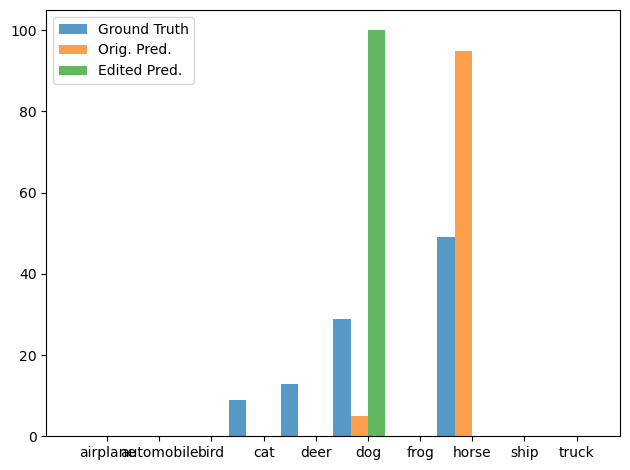

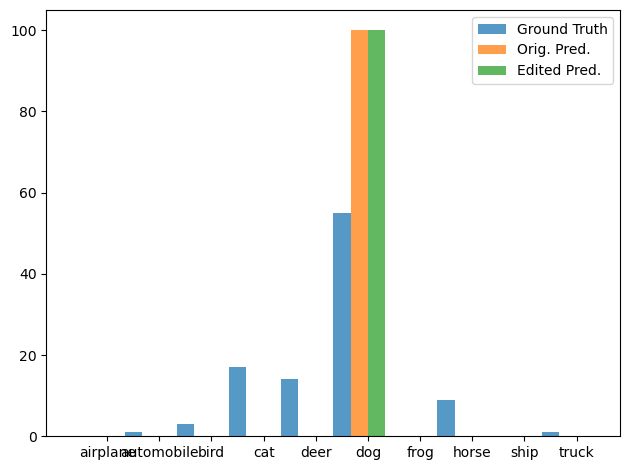

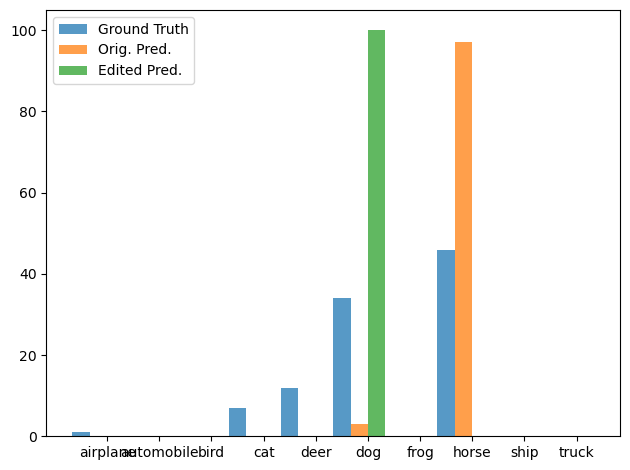

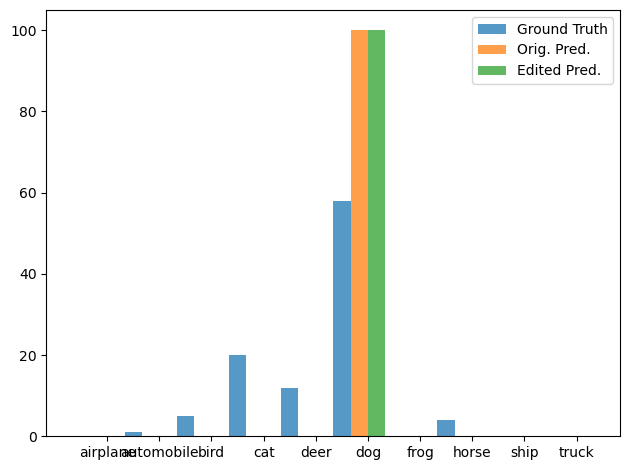

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_2/models
Finished trial 19/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/felzenszwalb_masked_2
Starting Trial 20/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/quickshift_masked_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n0211

100%|██████████████████████████████████████████| 274/274 [02:24<00:00,  1.89it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.11647254228591919 0.005923084449023008
L2 norm of weight change: 0.47470593452453613
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:09<00:00,  2.11it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5928, 5325, 5059, 4161, 4011, 3689, 5674,    0, 5378, 4175]), 'TN': array([60971, 61227, 59956, 58516, 60775, 55609, 60995, 63000, 60352,
       61999]), 'FPs': array([2029, 1773, 3044, 4484, 2225, 7391, 2005,    0, 2648, 1001]), 'FNs': array([1072, 1675, 1941, 2839, 2989, 3311, 1326, 7000, 1622, 2825]), 'accuracy': 0.62, 'per_class_accuracy': array([0.9557    , 0.95074286, 0.92878571, 0.89538571, 0.92551429,
       0.84711429, 0.95241429, 0.9       , 0.939     , 0.94534286]), 'per_class_accuracy_mean': 0.924, 'precision': array([0.7450044 , 0.75021133, 0.62433667, 0.48131868, 0.64320077,
       0.33294224, 0.73889829, 0.        , 0.67007227, 0.80660742]), 'precision_mean': 0.5792592058562941, 'recall': array([0.84685714, 0.76071429, 0.72271429, 0.59442857, 0.573     ,
       0.527     , 0.81057143, 0.        , 0.76828571, 0.59642857]), 'recall_mean': 0.6199999999999999, 'f1': array([0.79267233, 0.7554263 , 0.66993313, 0.53192713, 0.60607434,
       0.4

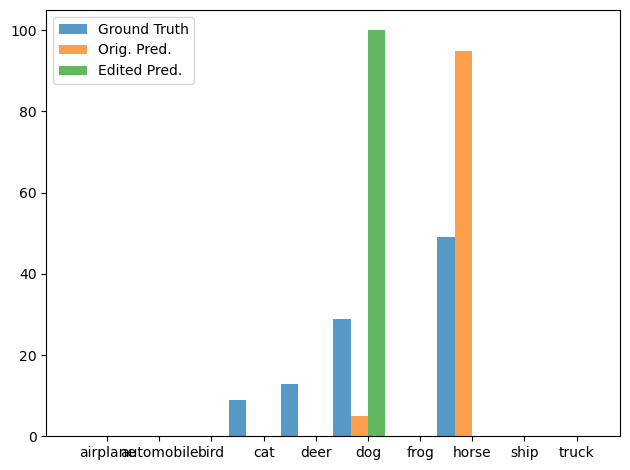

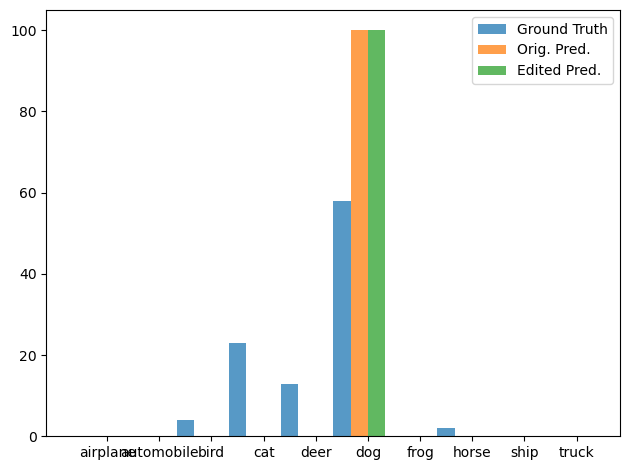

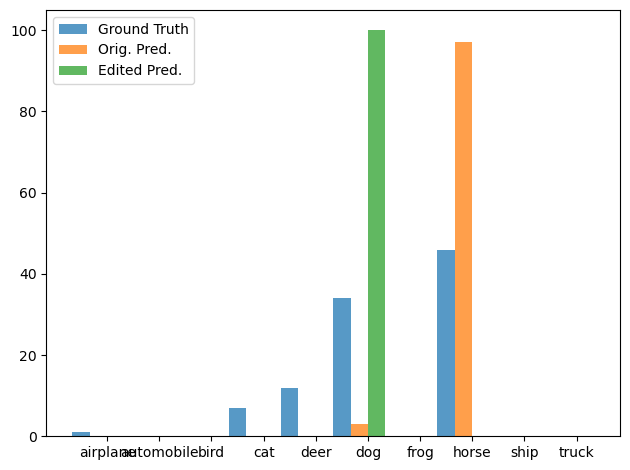

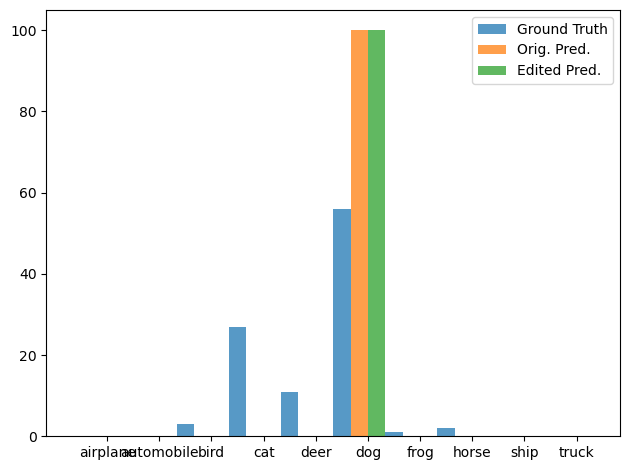

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_0/models
Finished trial 20/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_0
Starting Trial 21/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/quickshift_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n02116738_1

100%|██████████████████████████████████████████| 274/274 [01:59<00:00,  2.29it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07235199958086014 0.0043824161402881145
L2 norm of weight change: 0.2905633747577667
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:53<00:00,  2.41it/s]


Post-edit metrics: {'TP': array([5997, 5509, 5184, 3866, 4015, 3683, 5657, 4535, 5103, 4436]), 'TN': array([60720, 60932, 59569, 59644, 60721, 60094, 61069, 62438, 61196,
       61602]), 'FPs': array([2280, 2068, 3431, 3356, 2279, 2906, 1931,  562, 1804, 1398]), 'FNs': array([1003, 1491, 1816, 3134, 2985, 3317, 1343, 2465, 1897, 2564]), 'accuracy': 0.6855, 'per_class_accuracy': array([0.9531    , 0.94915714, 0.92504286, 0.90728571, 0.9248    ,
       0.9111    , 0.95322857, 0.95675714, 0.94712857, 0.9434    ]), 'per_class_accuracy_mean': 0.9371, 'precision': array([0.72453788, 0.72706876, 0.60174115, 0.53530878, 0.63790912,
       0.55896191, 0.74551924, 0.88973906, 0.73881569, 0.76037024]), 'precision_mean': 0.6919971831383478, 'recall': array([0.85671429, 0.787     , 0.74057143, 0.55228571, 0.57357143,
       0.52614286, 0.80814286, 0.64785714, 0.729     , 0.63371429]), 'recall_mean': 0.6855, 'f1': array([0.78510179, 0.75584825, 0.66397695, 0.54366474, 0.60403189,
       0.54205607, 

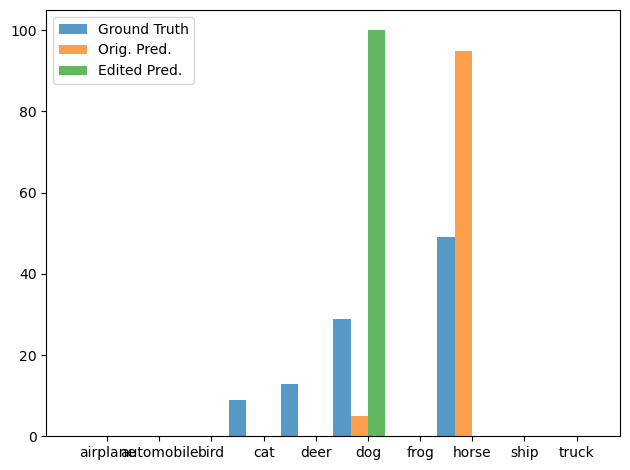

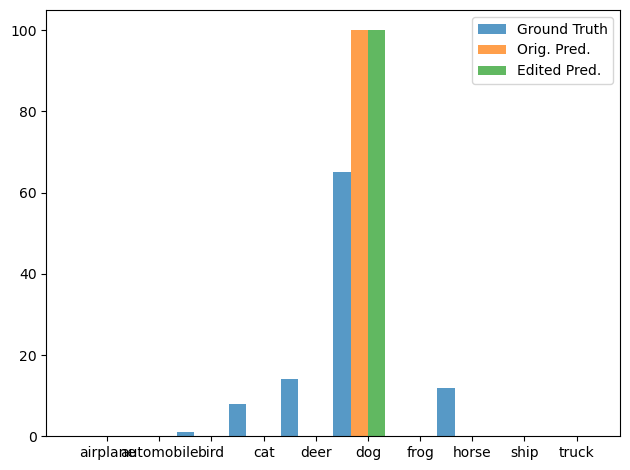

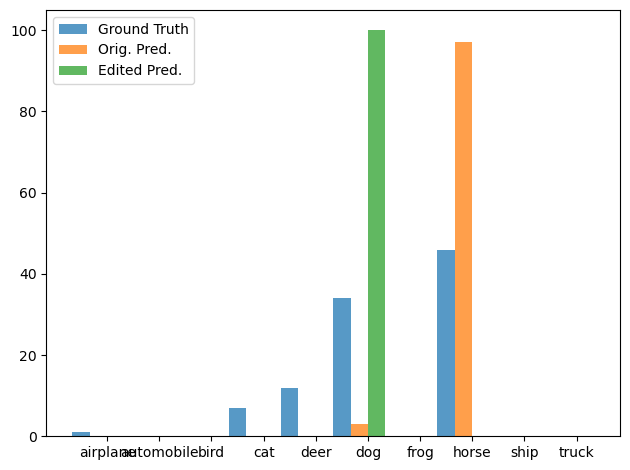

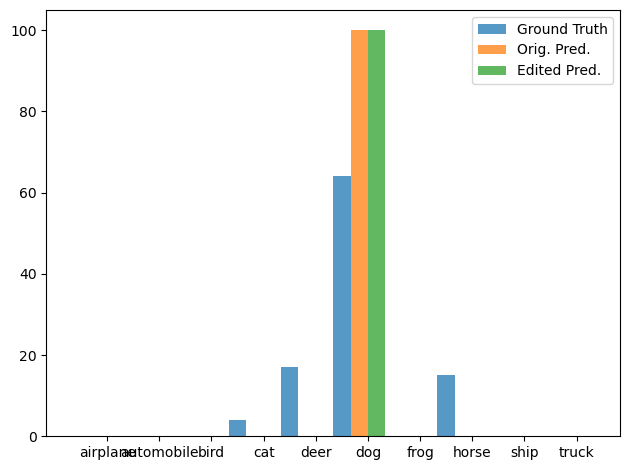

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_1/models
Finished trial 21/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/quickshift_masked_1
Starting Trial 22/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/slic_gaussian_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_gaussian_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n02116738_10613/mod

100%|██████████████████████████████████████████| 274/274 [01:52<00:00,  2.43it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.04528234153985977 0.006261900532990694
L2 norm of weight change: 0.1803947538137436
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:02<00:00,  2.24it/s]


Post-edit metrics: {'TP': array([6129, 5235, 5094, 4172, 4251, 2877, 5642, 4890, 4915, 4772]), 'TN': array([60149, 61361, 59754, 58816, 60156, 61868, 61118, 62090, 61531,
       61134]), 'FPs': array([2851, 1639, 3246, 4184, 2844, 1132, 1882,  910, 1469, 1866]), 'FNs': array([ 871, 1765, 1906, 2828, 2749, 4123, 1358, 2110, 2085, 2228]), 'accuracy': 0.6853857142857143, 'per_class_accuracy': array([0.94682857, 0.95137143, 0.9264    , 0.89982857, 0.9201    ,
       0.92492857, 0.95371429, 0.95685714, 0.94922857, 0.94151429]), 'per_class_accuracy_mean': 0.9370771428571428, 'precision': array([0.6825167 , 0.76156532, 0.61079137, 0.49928195, 0.59915433,
       0.71763532, 0.74986709, 0.84310345, 0.76989348, 0.71889123]), 'precision_mean': 0.6952700253195304, 'recall': array([0.87557143, 0.74785714, 0.72771429, 0.596     , 0.60728571,
       0.411     , 0.806     , 0.69857143, 0.70214286, 0.68171429]), 'recall_mean': 0.6853857142857144, 'f1': array([0.76708385, 0.75464898, 0.66414602, 0.54337

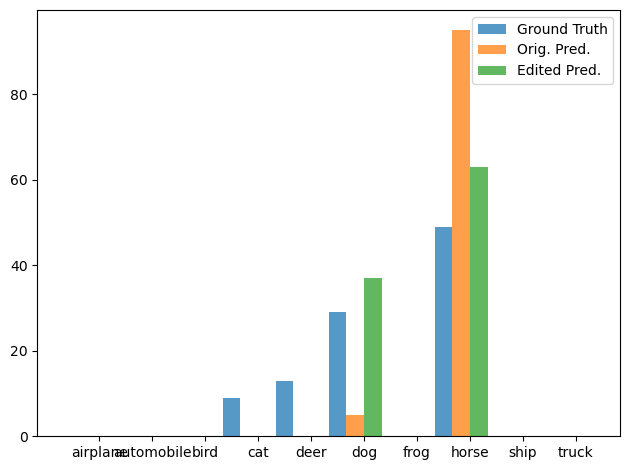

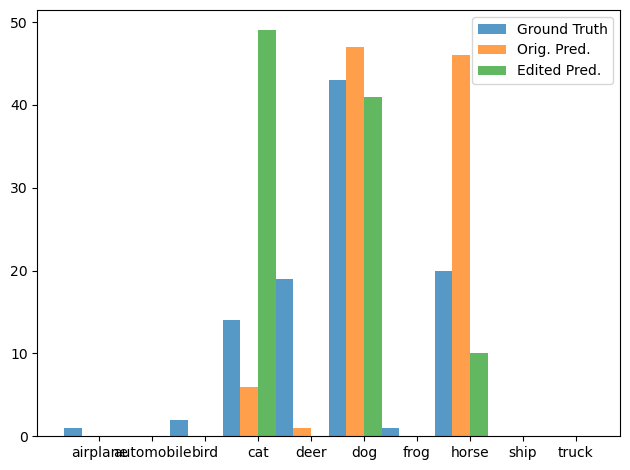

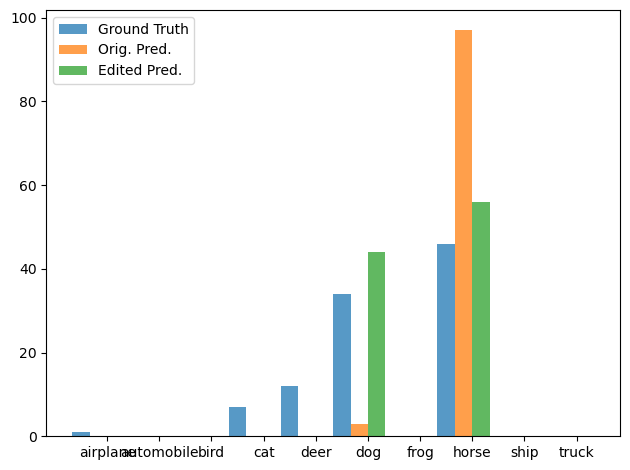

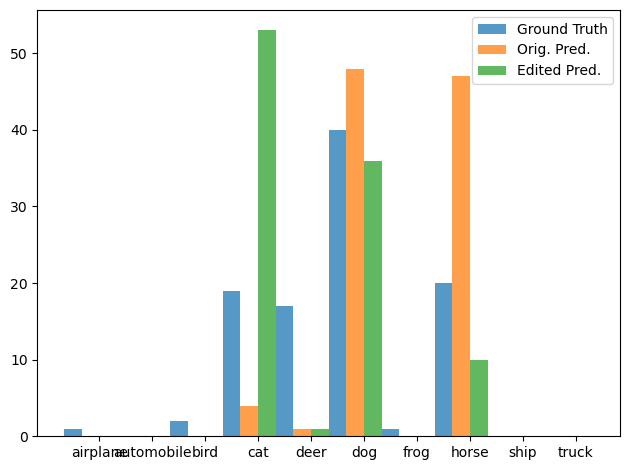

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_gaussian_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_gaussian_4/models
Finished trial 22/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_gaussian_4
Starting Trial 23/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/slic_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n02116738_10613/modified_images/sli

100%|██████████████████████████████████████████| 274/274 [01:41<00:00,  2.70it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09187689423561096 0.0048764850944280624
L2 norm of weight change: 0.42928215861320496
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:03<00:00,  2.22it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5965, 5310, 4975, 3757, 4820, 3304, 5746,    0, 5393, 4173]), 'TN': array([60812, 61256, 60143, 59807, 54528, 60932, 60743, 63000, 60246,
       61976]), 'FPs': array([2188, 1744, 2857, 3193, 8472, 2068, 2257,    0, 2754, 1024]), 'FNs': array([1035, 1690, 2025, 3243, 2180, 3696, 1254, 7000, 1607, 2827]), 'accuracy': 0.6206142857142857, 'per_class_accuracy': array([0.95395714, 0.95094286, 0.93025714, 0.90805714, 0.84782857,
       0.91765714, 0.94984286, 0.9       , 0.9377    , 0.94498571]), 'per_class_accuracy_mean': 0.9241228571428571, 'precision': array([0.73163253, 0.75276439, 0.6352145 , 0.54057554, 0.36262413,
       0.61504095, 0.71798076, 0.        , 0.66196146, 0.80296325]), 'precision_mean': 0.582075751242512, 'recall': array([0.85214286, 0.75857143, 0.71071429, 0.53671429, 0.68857143,
       0.472     , 0.82085714, 0.        , 0.77042857, 0.59614286]), 'recall_mean': 0.6206142857142857, 'f1': array([0.78730284, 0.75565675, 0.67084682, 0.538637

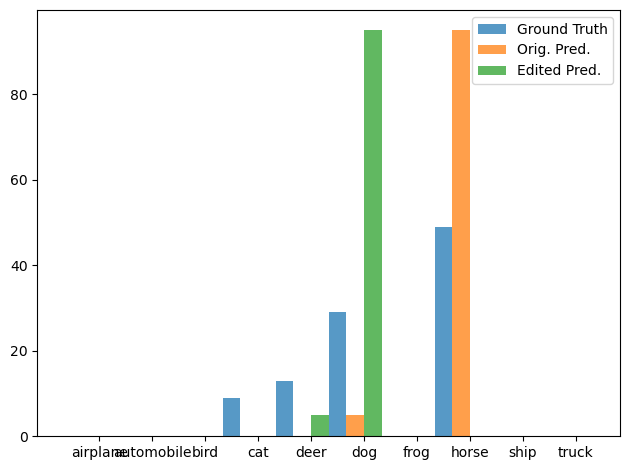

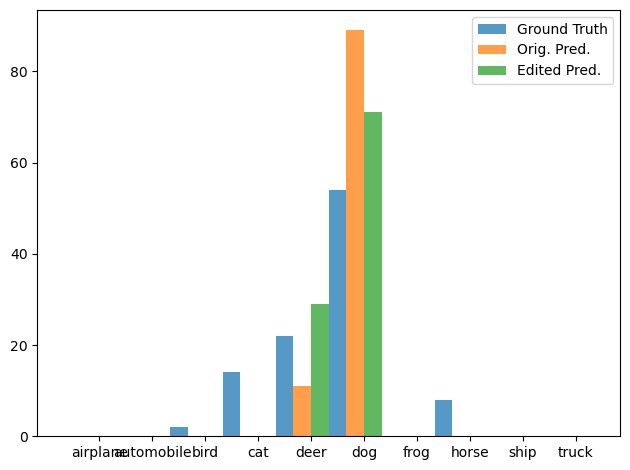

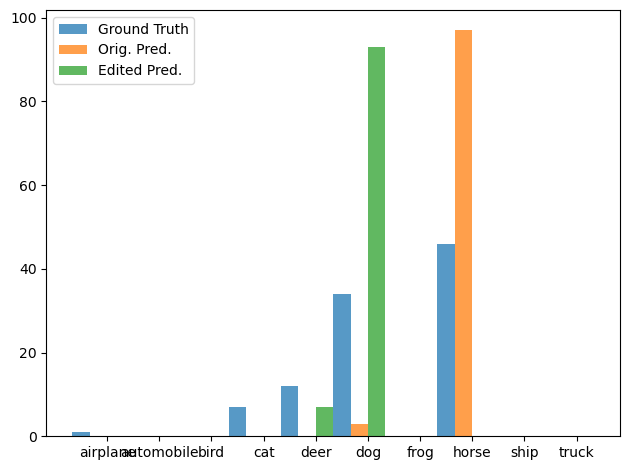

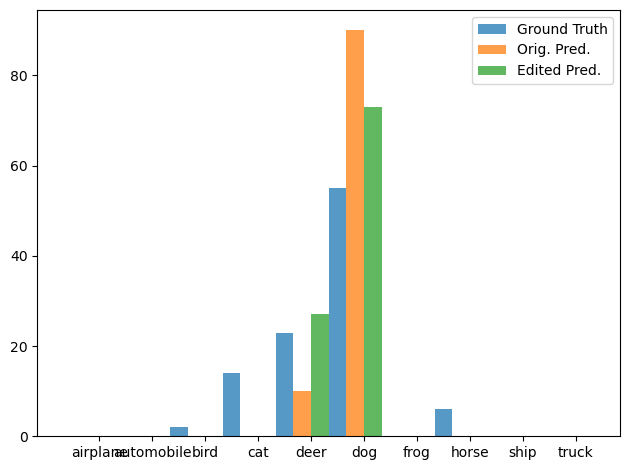

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_masked_1/models
Finished trial 23/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/slic_masked_1
Starting Trial 24/37...
Current run_id: 0112_121958/dog-train-n02116738_10613/watershed_gaussian_7
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/watershed_gaussian_7
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02116738_10613.png
Value images: saved/segmentations/dog-train-n02116738_10613/modified_im

100%|██████████████████████████████████████████| 274/274 [02:13<00:00,  2.05it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.03344409912824631 0.004317516461014748
L2 norm of weight change: 0.17670471966266632
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:06<00:00,  2.17it/s]


Post-edit metrics: {'TP': array([6116, 5397, 5191, 4013, 4071, 3162, 5622, 5034, 4865, 4640]), 'TN': array([60196, 61085, 59491, 59380, 60573, 61423, 61154, 61927, 61588,
       61294]), 'FPs': array([2804, 1915, 3509, 3620, 2427, 1577, 1846, 1073, 1412, 1706]), 'FNs': array([ 884, 1603, 1809, 2987, 2929, 3838, 1378, 1966, 2135, 2360]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94731429, 0.94974286, 0.92402857, 0.90561429, 0.92348571,
       0.92264286, 0.95394286, 0.95658571, 0.94932857, 0.94191429]), 'per_class_accuracy_mean': 0.9374600000000001, 'precision': array([0.68565022, 0.73810175, 0.59666667, 0.52574348, 0.62650046,
       0.66722937, 0.752812  , 0.82429998, 0.77505178, 0.73116924]), 'precision_mean': 0.6923224956918692, 'recall': array([0.87371429, 0.771     , 0.74157143, 0.57328571, 0.58157143,
       0.45171429, 0.80314286, 0.71914286, 0.695     , 0.66285714]), 'recall_mean': 0.6873, 'f1': array([0.76834171, 0.75419229, 0.66127389, 0.5484863 , 0.60320047,
       

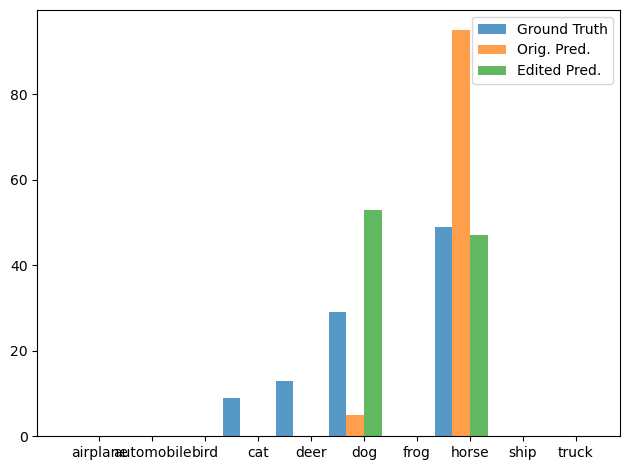

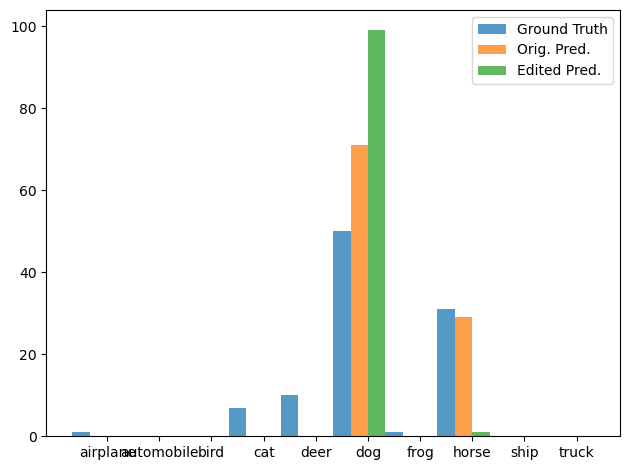

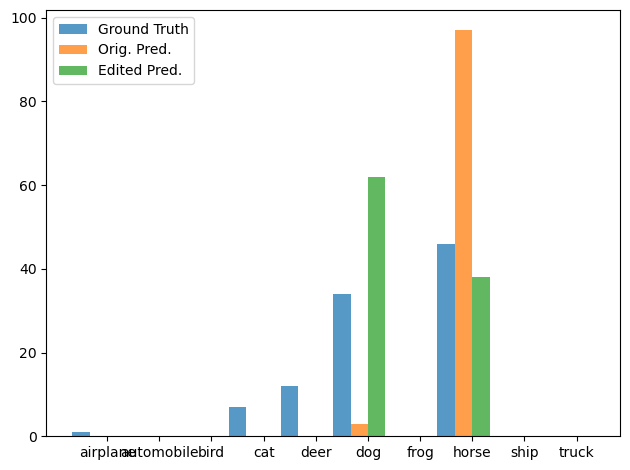

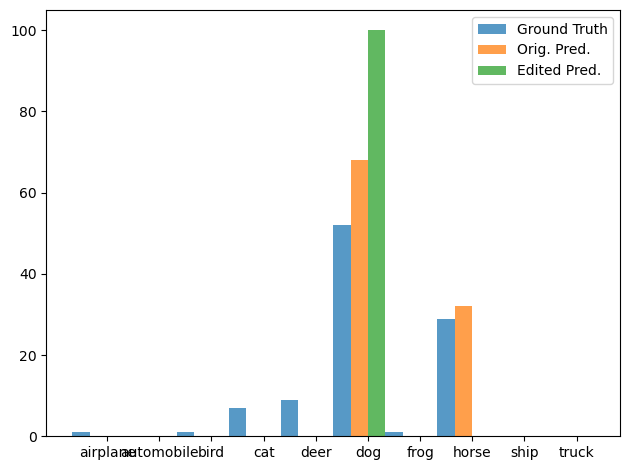

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/watershed_gaussian_7/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/watershed_gaussian_7/models
Finished trial 24/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02116738_10613/watershed_gaussian_7
Starting Trial 25/37...
Current run_id: 0112_121958/dog-train-n02114367_8883/quickshift_gaussian_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_gaussian_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114367_8883.png
Value images: saved/segmentations/dog-train-n021143

100%|██████████████████████████████████████████| 274/274 [01:36<00:00,  2.84it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07177223265171051 0.004108650144189596
L2 norm of weight change: 0.26026996970176697
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:09<00:00,  2.11it/s]


Post-edit metrics: {'TP': array([6067, 5510, 5358, 3904, 3635, 3498, 5569, 5237, 4784, 4558]), 'TN': array([60463, 60862, 58967, 59696, 61391, 60754, 61282, 61594, 61704,
       61407]), 'FPs': array([2537, 2138, 4033, 3304, 1609, 2246, 1718, 1406, 1296, 1593]), 'FNs': array([ 933, 1490, 1642, 3096, 3365, 3502, 1431, 1763, 2216, 2442]), 'accuracy': 0.6874285714285714, 'per_class_accuracy': array([0.95042857, 0.94817143, 0.91892857, 0.90857143, 0.92894286,
       0.91788571, 0.95501429, 0.95472857, 0.94982857, 0.94235714]), 'per_class_accuracy_mean': 0.9374857142857144, 'precision': array([0.70513715, 0.72044979, 0.57054627, 0.54162042, 0.69317315,
       0.60898329, 0.76423768, 0.78834864, 0.78684211, 0.74101772]), 'precision_mean': 0.6920356210109196, 'recall': array([0.86671429, 0.78714286, 0.76542857, 0.55771429, 0.51928571,
       0.49971429, 0.79557143, 0.74814286, 0.68342857, 0.65114286]), 'recall_mean': 0.6874285714285715, 'f1': array([0.77762112, 0.75232114, 0.65377341, 0.54954

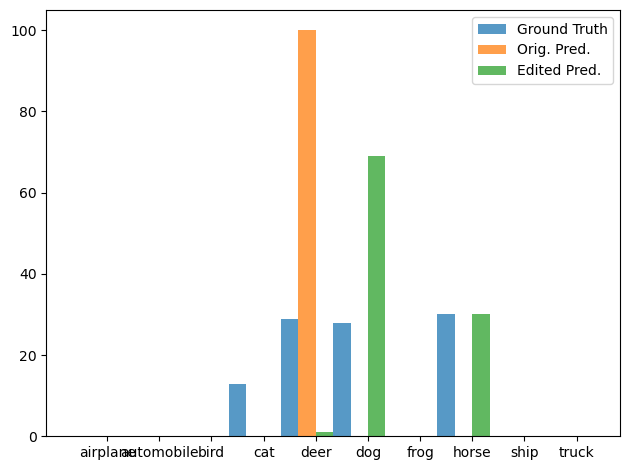

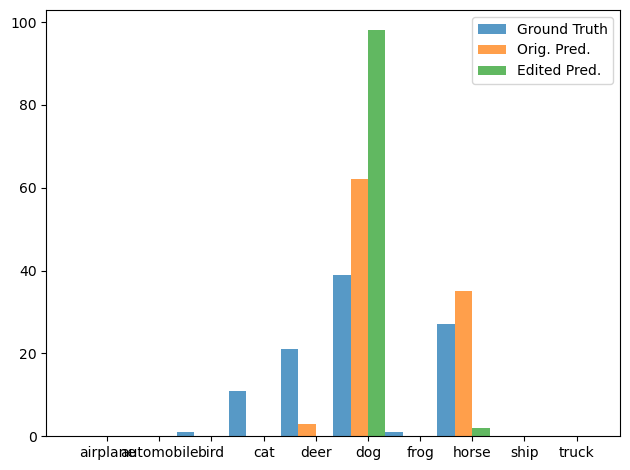

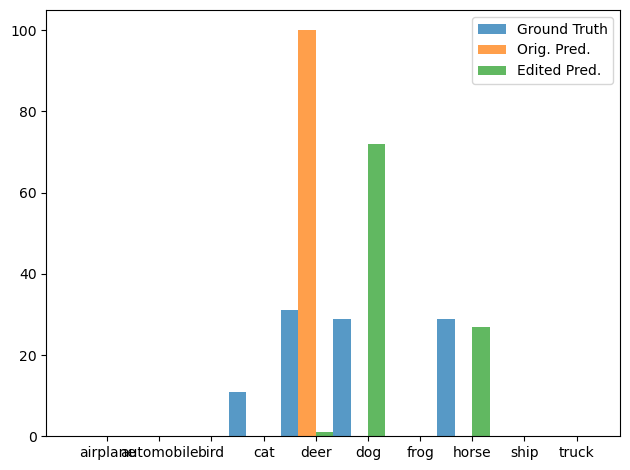

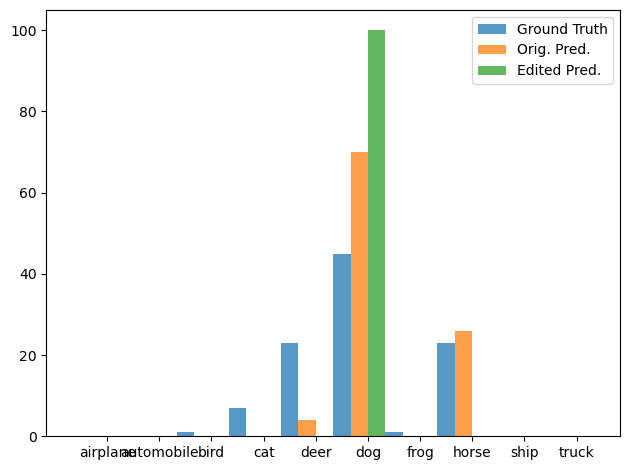

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_gaussian_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_gaussian_2/models
Finished trial 25/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_gaussian_2
Starting Trial 26/37...
Current run_id: 0112_121958/dog-train-n02114367_8883/quickshift_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114367_8883.png
Value images: saved/segmentations/dog-train-n02114367_8

100%|██████████████████████████████████████████| 274/274 [01:46<00:00,  2.58it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.13852357864379883 0.009950589388608932
L2 norm of weight change: 0.4751509130001068
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:20<00:00,  3.39it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:165: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:202: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6030, 5417, 5315, 4519,    0, 3887, 5476, 4374, 4936, 4577]), 'TN': array([60577, 61083, 59028, 57217, 63000, 56718, 61474, 62544, 61440,
       61450]), 'FPs': array([2423, 1917, 3972, 5783,    0, 6282, 1526,  456, 1560, 1550]), 'FNs': array([ 970, 1583, 1685, 2481, 7000, 3113, 1524, 2626, 2064, 2423]), 'accuracy': 0.6361571428571429, 'per_class_accuracy': array([0.95152857, 0.95      , 0.91918571, 0.88194286, 0.9       ,
       0.86578571, 0.95642857, 0.95597143, 0.94822857, 0.94324286]), 'per_class_accuracy_mean': 0.9272314285714286, 'precision': array([0.7133562 , 0.73861467, 0.57230537, 0.43865269, 0.        ,
       0.38224014, 0.78206227, 0.90559006, 0.75985222, 0.74702138]), 'precision_mean': 0.6039695007356147, 'recall': array([0.86142857, 0.77385714, 0.75928571, 0.64557143, 0.        ,
       0.55528571, 0.78228571, 0.62485714, 0.70514286, 0.65385714]), 'recall_mean': 0.6361571428571429, 'f1': array([0.78043098, 0.75582531, 0.65266777, 0.52236

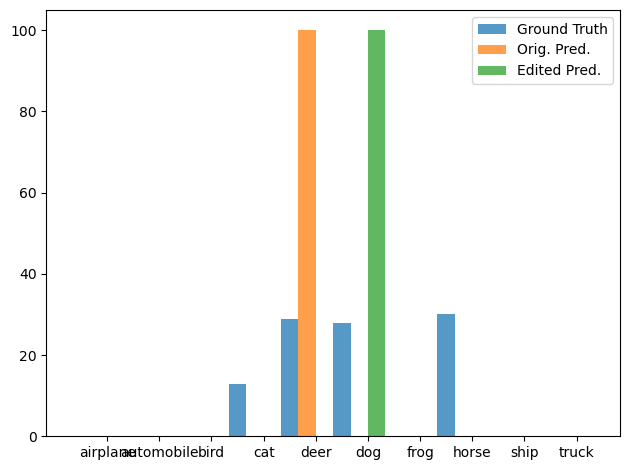

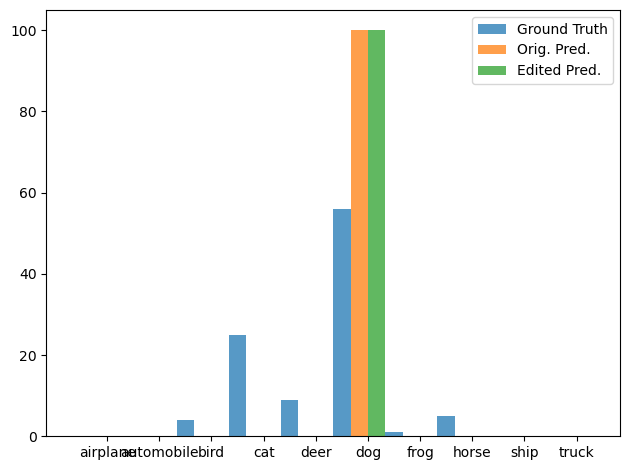

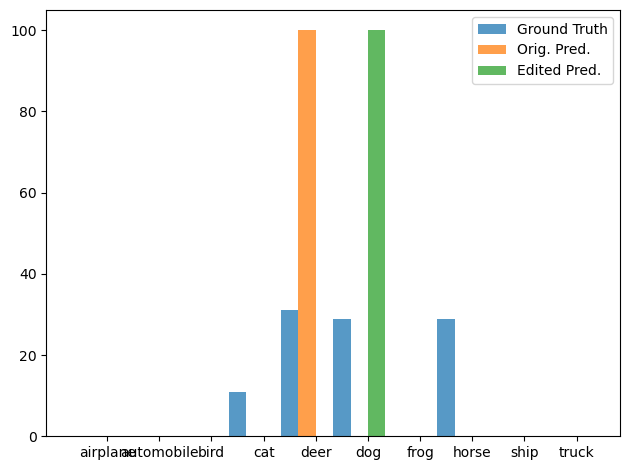

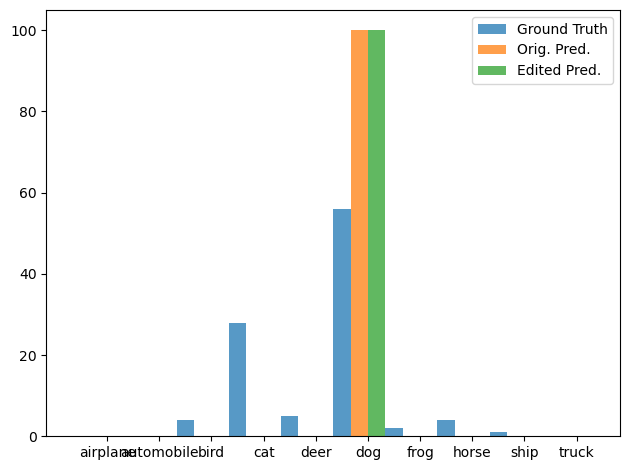

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_masked_2/models
Finished trial 26/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/quickshift_masked_2
Starting Trial 27/37...
Current run_id: 0112_121958/dog-train-n02114367_8883/watershed_gaussian_0
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_gaussian_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114367_8883.png
Value images: saved/segmentations/dog-train-n02114367_8883/

100%|██████████████████████████████████████████| 274/274 [01:17<00:00,  3.53it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06842872500419617 0.0038973663467913866
L2 norm of weight change: 0.24943502247333527
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:12<00:00,  3.80it/s]


Post-edit metrics: {'TP': array([6044, 5526, 5270, 3892, 3779, 3566, 5627, 5050, 4881, 4505]), 'TN': array([60551, 60856, 59285, 59669, 61179, 60529, 61145, 61906, 61544,
       61476]), 'FPs': array([2449, 2144, 3715, 3331, 1821, 2471, 1855, 1094, 1456, 1524]), 'FNs': array([ 956, 1474, 1730, 3108, 3221, 3434, 1373, 1950, 2119, 2495]), 'accuracy': 0.6877142857142857, 'per_class_accuracy': array([0.95135714, 0.94831429, 0.92221429, 0.90801429, 0.92797143,
       0.91564286, 0.95388571, 0.95651429, 0.94892857, 0.94258571]), 'per_class_accuracy_mean': 0.9375428571428571, 'precision': array([0.71164488, 0.72046936, 0.58653311, 0.53883428, 0.67482143,
       0.59069074, 0.75207164, 0.8219401 , 0.77023828, 0.74722176]), 'precision_mean': 0.6914465591651682, 'recall': array([0.86342857, 0.78942857, 0.75285714, 0.556     , 0.53985714,
       0.50942857, 0.80385714, 0.72142857, 0.69728571, 0.64357143]), 'recall_mean': 0.6877142857142857, 'f1': array([0.78022333, 0.75337423, 0.65936816, 0.54728

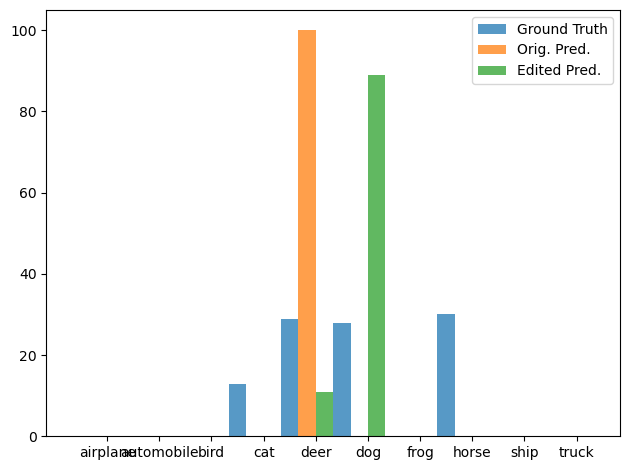

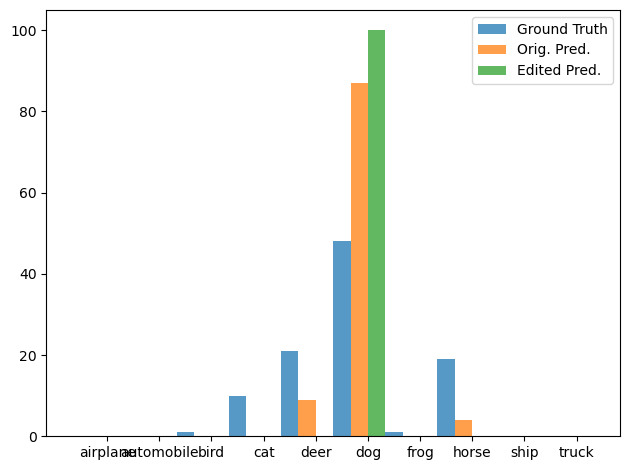

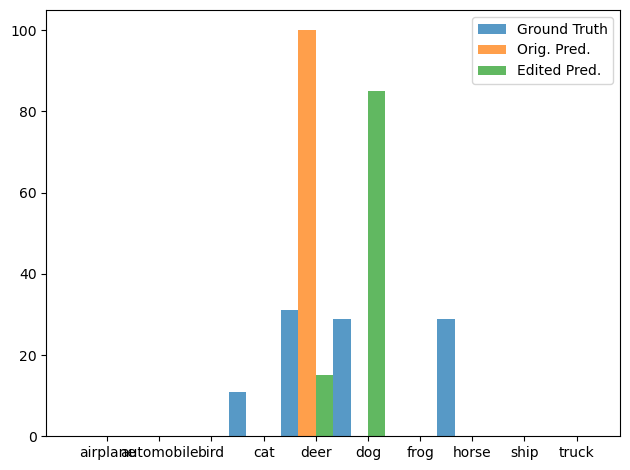

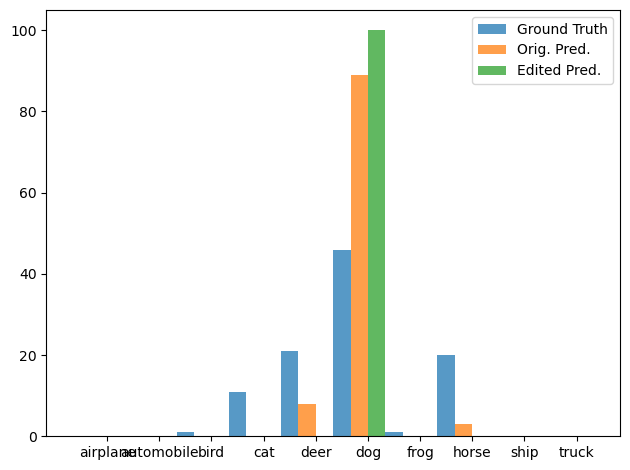

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_gaussian_0/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_gaussian_0/models
Finished trial 27/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_gaussian_0
Starting Trial 28/37...
Current run_id: 0112_121958/dog-train-n02114367_8883/watershed_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114367_8883.png
Value images: saved/segmentations/dog-train-n02114367_8883/m

100%|██████████████████████████████████████████| 274/274 [01:04<00:00,  4.26it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.07475890219211578 0.004605640657246113
L2 norm of weight change: 0.3004303574562073
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:10<00:00,  3.88it/s]


Post-edit metrics: {'TP': array([6014, 5566, 5232, 3776, 3866, 3809, 5656, 4675, 5023, 4338]), 'TN': array([60663, 60783, 59436, 59943, 61011, 59720, 61085, 62327, 61290,
       61697]), 'FPs': array([2337, 2217, 3564, 3057, 1989, 3280, 1915,  673, 1710, 1303]), 'FNs': array([ 986, 1434, 1768, 3224, 3134, 3191, 1344, 2325, 1977, 2662]), 'accuracy': 0.6850714285714286, 'per_class_accuracy': array([0.95252857, 0.94784286, 0.92382857, 0.91027143, 0.92681429,
       0.90755714, 0.95344286, 0.95717143, 0.94732857, 0.94335714]), 'per_class_accuracy_mean': 0.9370142857142858, 'precision': array([0.72015328, 0.7151484 , 0.59481583, 0.55261232, 0.66029035,
       0.53731133, 0.74706115, 0.87415856, 0.74602703, 0.76901259]), 'precision_mean': 0.6916590836696979, 'recall': array([0.85914286, 0.79514286, 0.74742857, 0.53942857, 0.55228571,
       0.54414286, 0.808     , 0.66785714, 0.71757143, 0.61971429]), 'recall_mean': 0.6850714285714286, 'f1': array([0.78353202, 0.75302713, 0.66244619, 0.54594

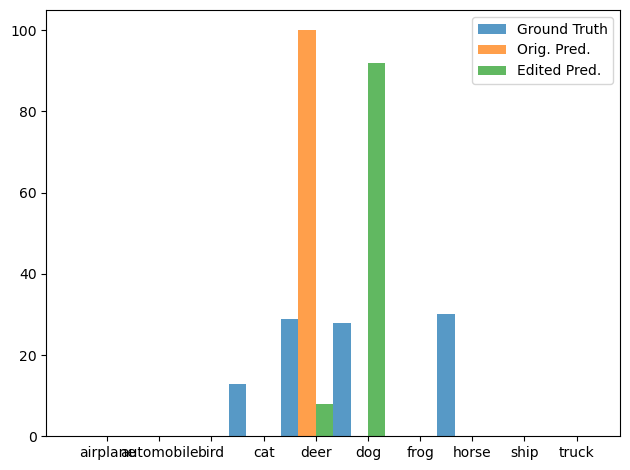

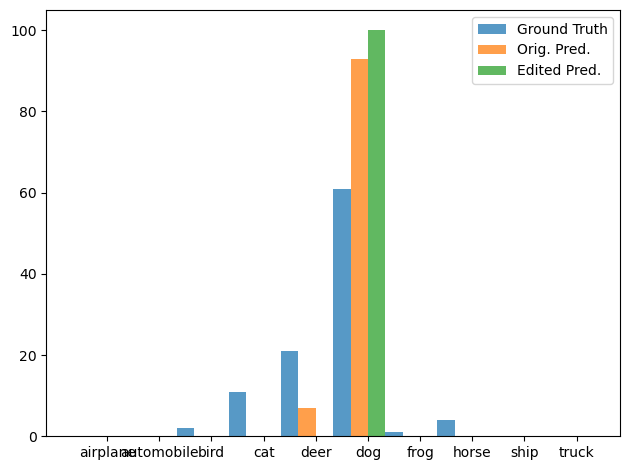

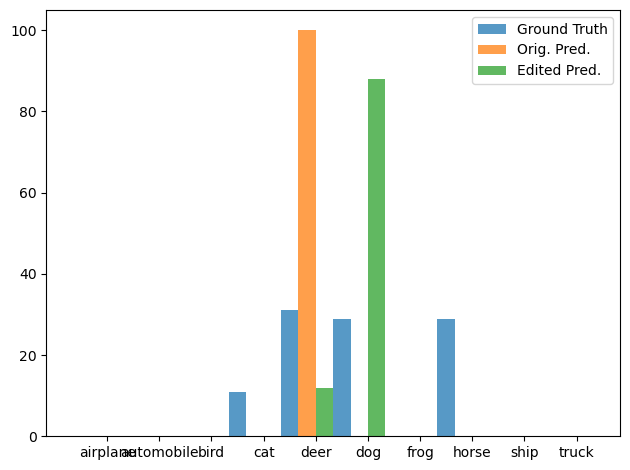

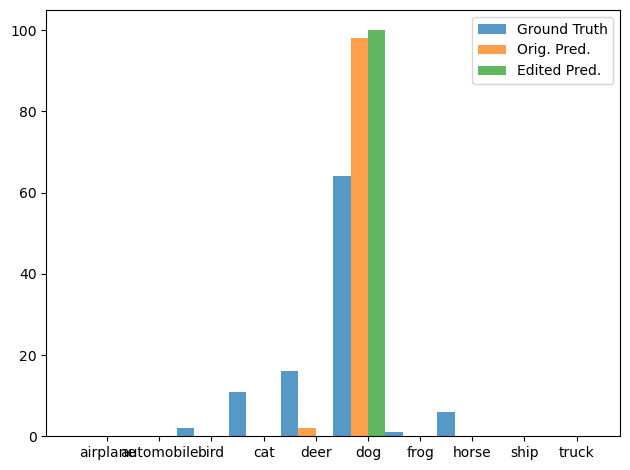

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_4/models
Finished trial 28/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_4
Starting Trial 29/37...
Current run_id: 0112_121958/dog-train-n02114367_8883/watershed_masked_7
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_7
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02114367_8883.png
Value images: saved/segmentations/dog-train-n02114367_8883/modifie

100%|██████████████████████████████████████████| 274/274 [01:13<00:00,  3.73it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.059126999229192734 0.003711362835019827
L2 norm of weight change: 0.23308897018432617
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [01:06<00:00,  4.14it/s]


Post-edit metrics: {'TP': array([6079, 5507, 5275, 3888, 3787, 3398, 5605, 5280, 4781, 4576]), 'TN': array([60429, 60876, 59285, 59743, 61102, 60941, 61207, 61518, 61713,
       61362]), 'FPs': array([2571, 2124, 3715, 3257, 1898, 2059, 1793, 1482, 1287, 1638]), 'FNs': array([ 921, 1493, 1725, 3112, 3213, 3602, 1395, 1720, 2219, 2424]), 'accuracy': 0.6882285714285714, 'per_class_accuracy': array([0.95011429, 0.94832857, 0.92228571, 0.90901429, 0.92698571,
       0.91912857, 0.95445714, 0.95425714, 0.94991429, 0.94197143]), 'per_class_accuracy_mean': 0.9376457142857142, 'precision': array([0.70277457, 0.72166164, 0.58676307, 0.54415675, 0.66613896,
       0.62268646, 0.7576372 , 0.78083407, 0.78790376, 0.73640167]), 'precision_mean': 0.6906958155823588, 'recall': array([0.86842857, 0.78671429, 0.75357143, 0.55542857, 0.541     ,
       0.48542857, 0.80071429, 0.75428571, 0.683     , 0.65371429]), 'recall_mean': 0.6882285714285714, 'f1': array([0.77686901, 0.75278518, 0.65978737, 0.54973

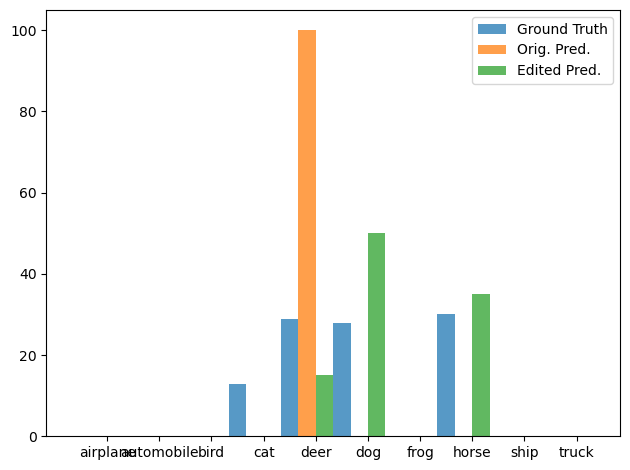

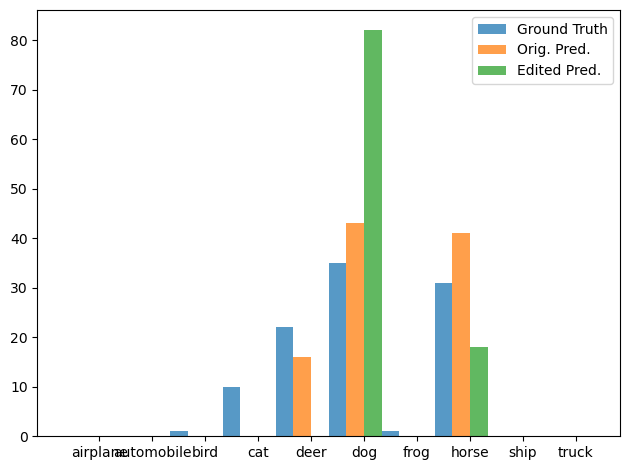

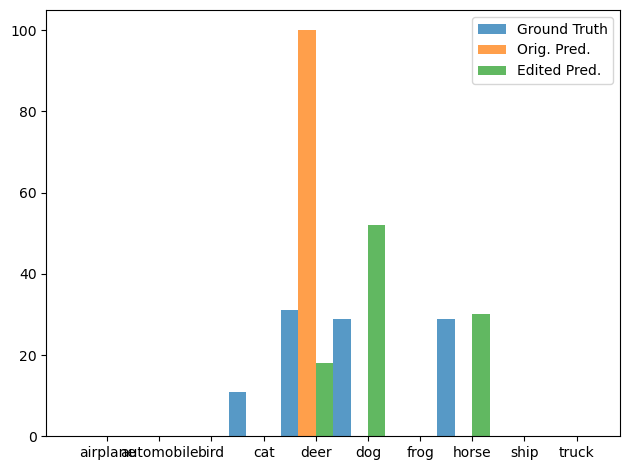

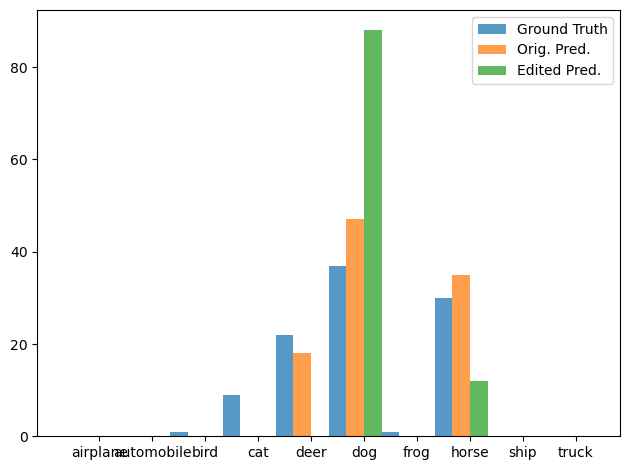

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_7/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_7/models
Finished trial 29/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114367_8883/watershed_masked_7
Starting Trial 30/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/felzenszwalb_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/felzenszwalb_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/m

100%|██████████████████████████████████████████| 274/274 [01:12<00:00,  3.79it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.05433225631713867 0.0037243992555886507
L2 norm of weight change: 0.18692556023597717
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:01<00:00,  2.26it/s]


Post-edit metrics: {'TP': array([6083, 5552, 5251, 3288, 4278, 3519, 5645, 5153, 4925, 4474]), 'TN': array([60341, 60788, 59269, 60980, 60075, 60933, 61082, 61736, 61470,
       61494]), 'FPs': array([2659, 2212, 3731, 2020, 2925, 2067, 1918, 1264, 1530, 1506]), 'FNs': array([ 917, 1448, 1749, 3712, 2722, 3481, 1355, 1847, 2075, 2526]), 'accuracy': 0.6881142857142857, 'per_class_accuracy': array([0.94891429, 0.94771429, 0.92171429, 0.91811429, 0.91932857,
       0.92074286, 0.95324286, 0.95555714, 0.9485    , 0.9424    ]), 'per_class_accuracy_mean': 0.937622857142857, 'precision': array([0.69583619, 0.71509531, 0.58461367, 0.61944235, 0.5939192 ,
       0.62996778, 0.74639693, 0.80302322, 0.76297444, 0.74816054]), 'precision_mean': 0.6899429630203524, 'recall': array([0.869     , 0.79314286, 0.75014286, 0.46971429, 0.61114286,
       0.50271429, 0.80642857, 0.73614286, 0.70357143, 0.63914286]), 'recall_mean': 0.6881142857142856, 'f1': array([0.772837  , 0.7520997 , 0.65711425, 0.534286

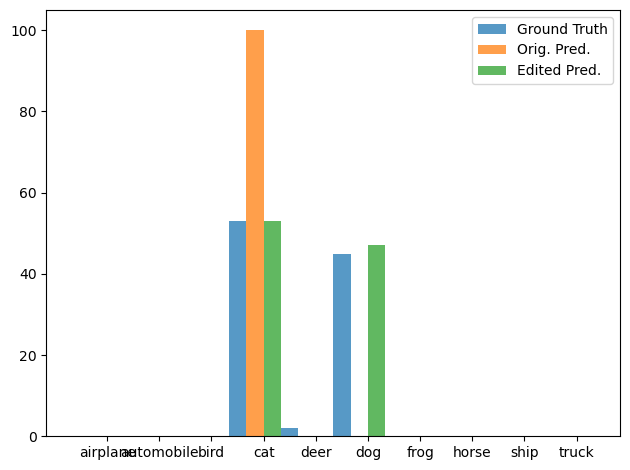

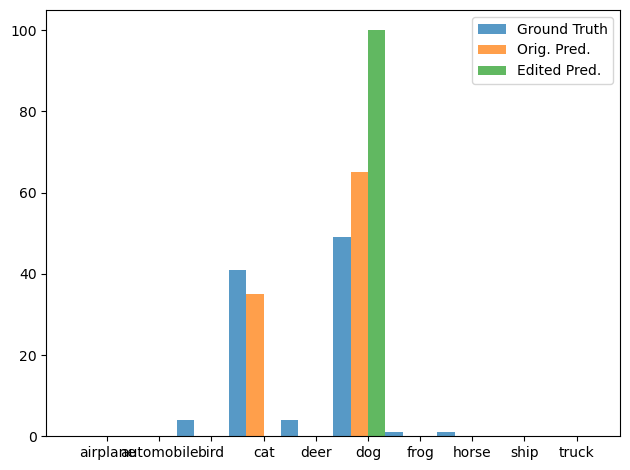

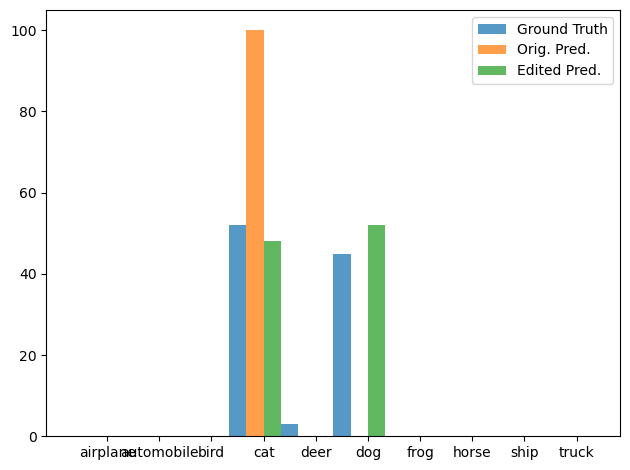

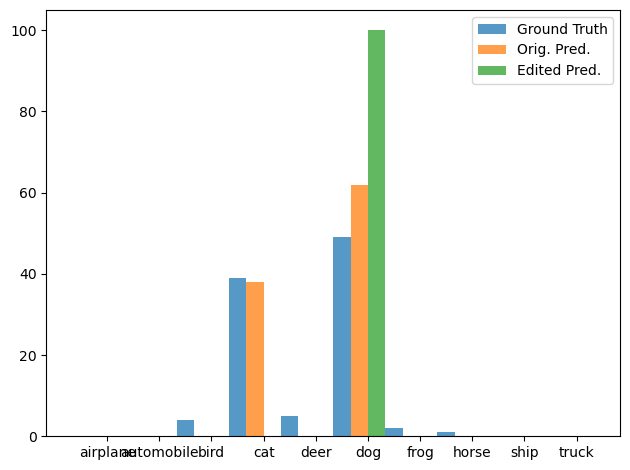

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/felzenszwalb_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/felzenszwalb_masked_2/models
Finished trial 30/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/felzenszwalb_masked_2
Starting Trial 31/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/slic_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modified

100%|██████████████████████████████████████████| 274/274 [02:21<00:00,  1.94it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09514627605676651 0.013531908392906189
L2 norm of weight change: 0.26999011635780334
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:10<00:00,  2.10it/s]


Post-edit metrics: {'TP': array([6138, 5596, 5412, 2768, 4300, 3239, 5709, 5277, 4754, 4472]), 'TN': array([60064, 60639, 58422, 61770, 59963, 61471, 60799, 61410, 61692,
       61435]), 'FPs': array([2936, 2361, 4578, 1230, 3037, 1529, 2201, 1590, 1308, 1565]), 'FNs': array([ 862, 1404, 1588, 4232, 2700, 3761, 1291, 1723, 2246, 2528]), 'accuracy': 0.6809285714285714, 'per_class_accuracy': array([0.94574286, 0.94621429, 0.91191429, 0.92197143, 0.91804286,
       0.92442857, 0.95011429, 0.95267143, 0.94922857, 0.94152857]), 'per_class_accuracy_mean': 0.9361857142857144, 'precision': array([0.67643818, 0.70328013, 0.54174174, 0.69234617, 0.5860706 ,
       0.67932047, 0.72174463, 0.76845784, 0.78422963, 0.74076528]), 'precision_mean': 0.6894394668259124, 'recall': array([0.87685714, 0.79942857, 0.77314286, 0.39542857, 0.61428571,
       0.46271429, 0.81557143, 0.75385714, 0.67914286, 0.63885714]), 'recall_mean': 0.6809285714285714, 'f1': array([0.76371781, 0.7482784 , 0.63708064, 0.50336

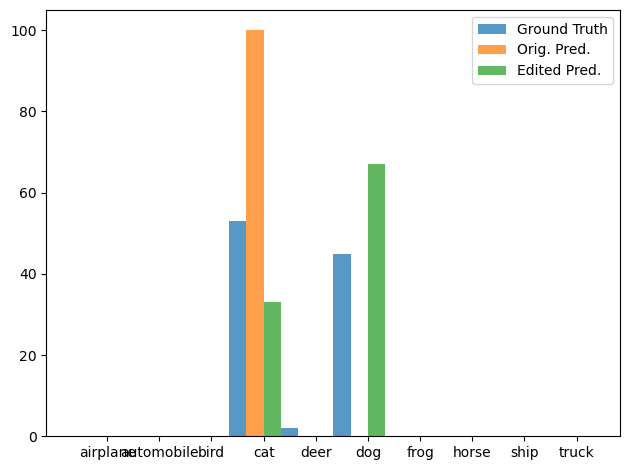

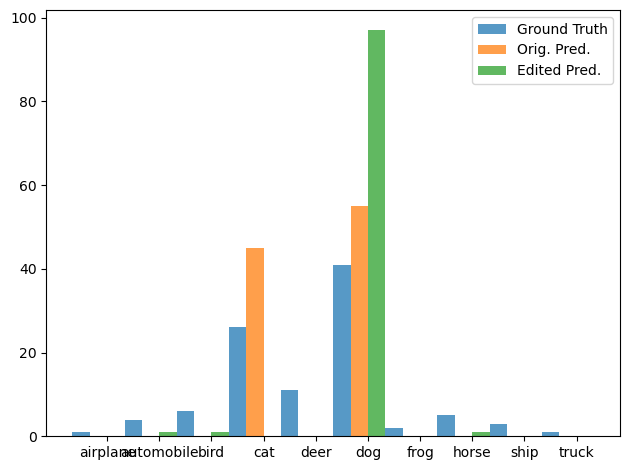

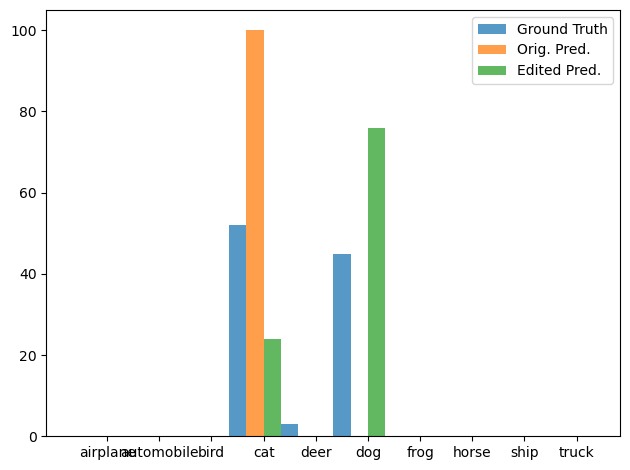

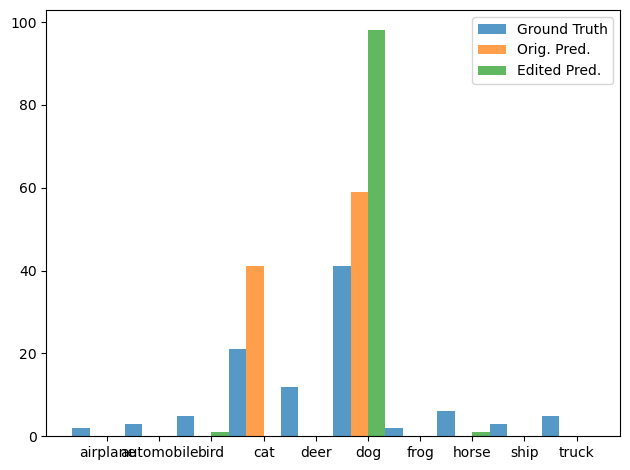

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_2/models
Finished trial 31/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_2
Starting Trial 32/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/slic_masked_4
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modified_images/slic_masked_4.pn

100%|██████████████████████████████████████████| 274/274 [01:55<00:00,  2.37it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.09642259776592255 0.004868924617767334
L2 norm of weight change: 0.307567298412323
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [08:23<00:00,  1.84s/it]


Post-edit metrics: {'TP': array([6023, 5681, 5268, 1869, 4270, 4324, 5620, 5168, 4925, 4325]), 'TN': array([60657, 60486, 59269, 62452, 60118, 58438, 61158, 61737, 61459,
       61699]), 'FPs': array([2343, 2514, 3731,  548, 2882, 4562, 1842, 1263, 1541, 1301]), 'FNs': array([ 977, 1319, 1732, 5131, 2730, 2676, 1380, 1832, 2075, 2675]), 'accuracy': 0.6781857142857143, 'per_class_accuracy': array([0.95257143, 0.94524286, 0.92195714, 0.91887143, 0.91982857,
       0.8966    , 0.95397143, 0.95578571, 0.94834286, 0.9432    ]), 'per_class_accuracy_mean': 0.9356371428571428, 'precision': array([0.71993784, 0.69322758, 0.58539838, 0.77327265, 0.59703579,
       0.48660815, 0.75314929, 0.80360753, 0.76167646, 0.76875222]), 'precision_mean': 0.6942665892019628, 'recall': array([0.86042857, 0.81157143, 0.75257143, 0.267     , 0.61      ,
       0.61771429, 0.80285714, 0.73828571, 0.70357143, 0.61785714]), 'recall_mean': 0.6781857142857143, 'f1': array([0.78393857, 0.74774597, 0.65854116, 0.39694

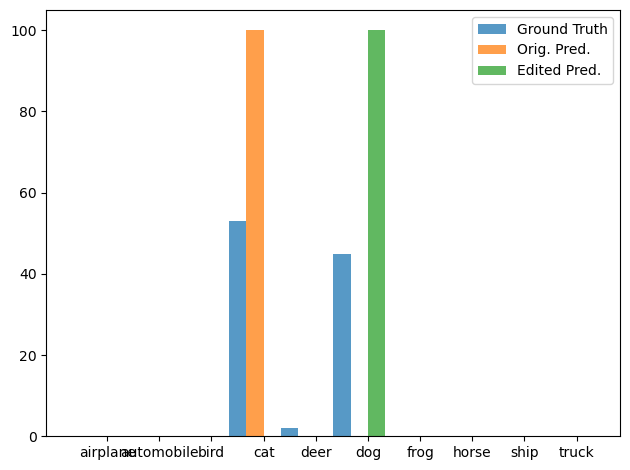

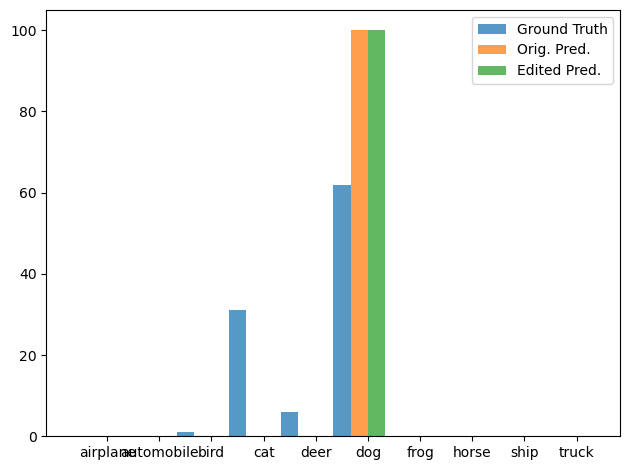

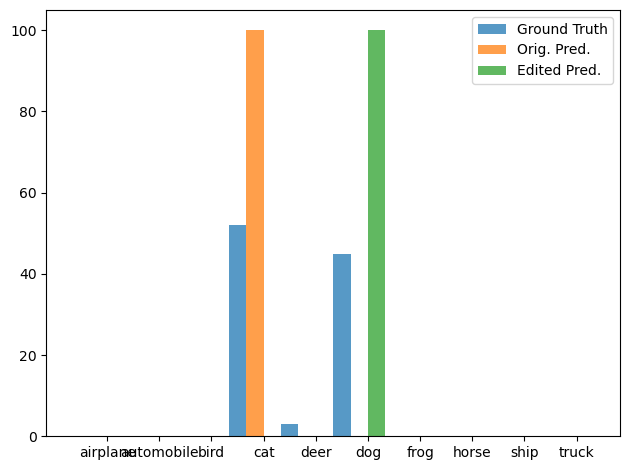

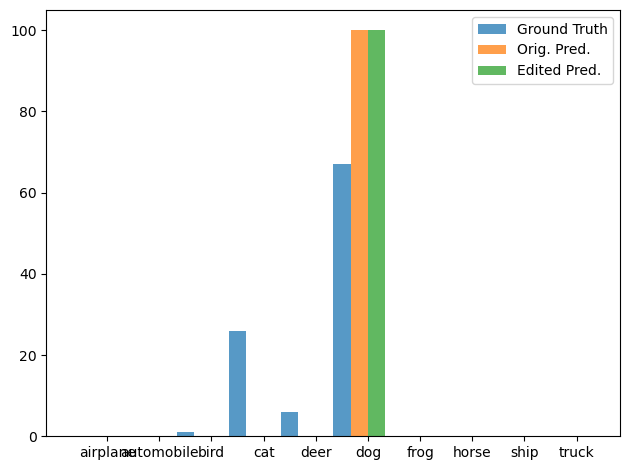

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_4/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_4/models
Finished trial 32/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_4
Starting Trial 33/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/slic_masked_5
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modified_images/slic_masked_5.pn

100%|██████████████████████████████████████████| 274/274 [02:47<00:00,  1.64it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06112149357795715 0.004333964549005032
L2 norm of weight change: 0.19979460537433624
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:28<00:00,  1.84it/s]


Post-edit metrics: {'TP': array([6096, 5567, 5311, 3151, 4269, 3479, 5632, 5177, 4884, 4452]), 'TN': array([60258, 60739, 58931, 61199, 60085, 61015, 61090, 61672, 61511,
       61518]), 'FPs': array([2742, 2261, 4069, 1801, 2915, 1985, 1910, 1328, 1489, 1482]), 'FNs': array([ 904, 1433, 1689, 3849, 2731, 3521, 1368, 1823, 2116, 2548]), 'accuracy': 0.6859714285714286, 'per_class_accuracy': array([0.94791429, 0.94722857, 0.91774286, 0.91928571, 0.91934286,
       0.92134286, 0.95317143, 0.95498571, 0.9485    , 0.94242857]), 'per_class_accuracy_mean': 0.9371942857142856, 'precision': array([0.68974881, 0.71116505, 0.56620469, 0.63630856, 0.59423719,
       0.63671303, 0.74675152, 0.79584935, 0.76635807, 0.75025278]), 'precision_mean': 0.6893589063189701, 'recall': array([0.87085714, 0.79528571, 0.75871429, 0.45014286, 0.60985714,
       0.497     , 0.80457143, 0.73957143, 0.69771429, 0.636     ]), 'recall_mean': 0.6859714285714286, 'f1': array([0.76979417, 0.75087672, 0.64847375, 0.52727

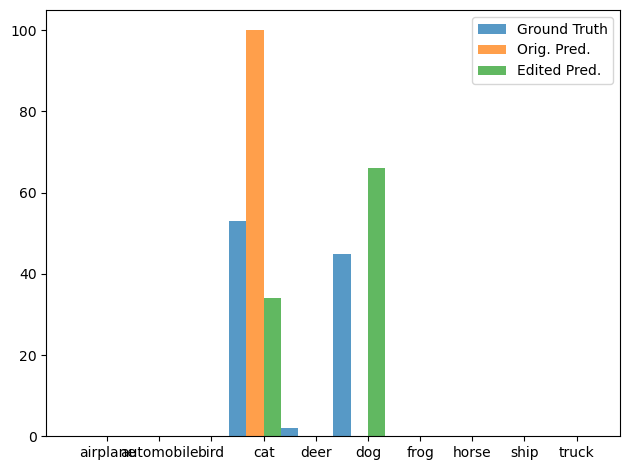

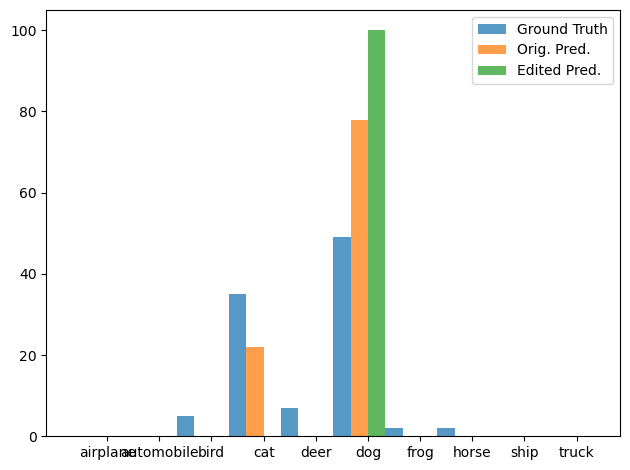

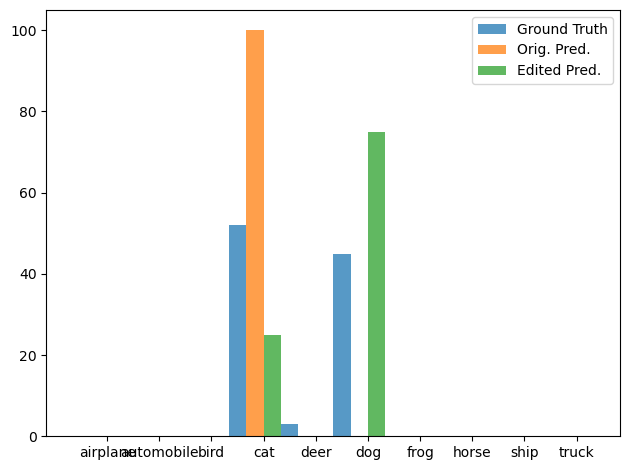

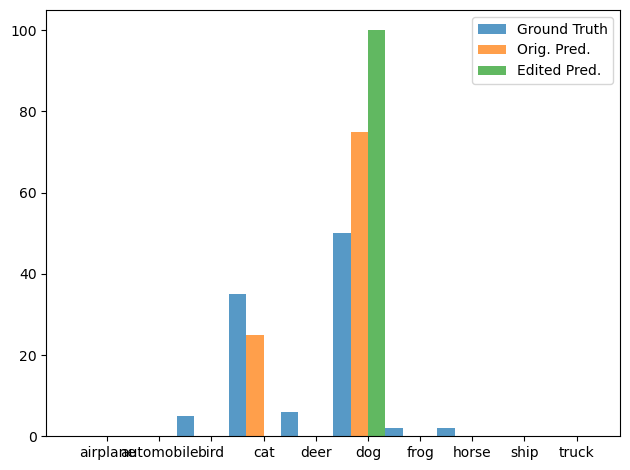

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_5/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_5/models
Finished trial 33/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/slic_masked_5
Starting Trial 34/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/watershed_masked_1
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modified_images/waters

100%|██████████████████████████████████████████| 274/274 [02:16<00:00,  2.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.08134215325117111 0.0041168443858623505
L2 norm of weight change: 0.2508794665336609
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:08<00:00,  2.13it/s]


Post-edit metrics: {'TP': array([6050, 5606, 5400, 2846, 4264, 3756, 5606, 5147, 4916, 4377]), 'TN': array([60470, 60691, 58608, 61627, 60110, 60465, 61139, 61749, 61463,
       61646]), 'FPs': array([2530, 2309, 4392, 1373, 2890, 2535, 1861, 1251, 1537, 1354]), 'FNs': array([ 950, 1394, 1600, 4154, 2736, 3244, 1394, 1853, 2084, 2623]), 'accuracy': 0.6852571428571429, 'per_class_accuracy': array([0.95028571, 0.9471    , 0.9144    , 0.92104286, 0.91962857,
       0.91744286, 0.9535    , 0.95565714, 0.94827143, 0.94318571]), 'per_class_accuracy_mean': 0.9370514285714286, 'precision': array([0.70512821, 0.70827543, 0.55147059, 0.67456743, 0.59603019,
       0.5970434 , 0.75077005, 0.80447015, 0.76181621, 0.76374106]), 'precision_mean': 0.6913312709787012, 'recall': array([0.86428571, 0.80085714, 0.77142857, 0.40657143, 0.60914286,
       0.53657143, 0.80085714, 0.73528571, 0.70228571, 0.62528571]), 'recall_mean': 0.6852571428571428, 'f1': array([0.77663671, 0.75172645, 0.64316341, 0.50735

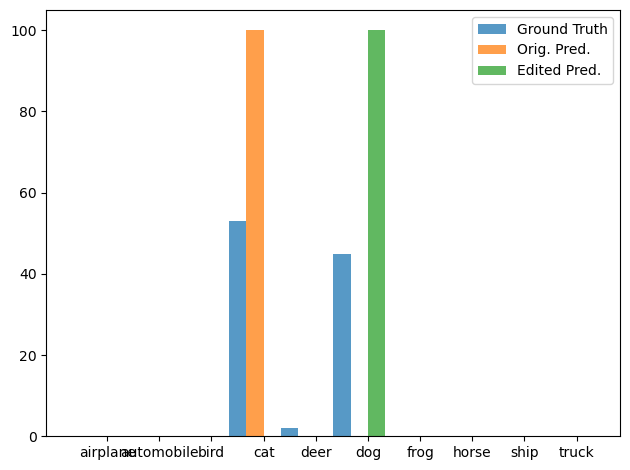

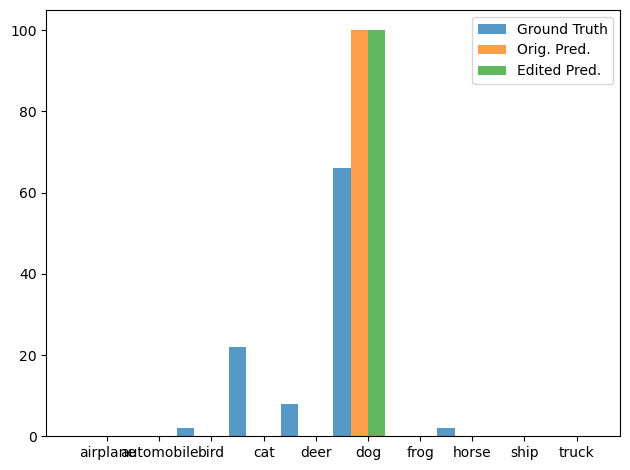

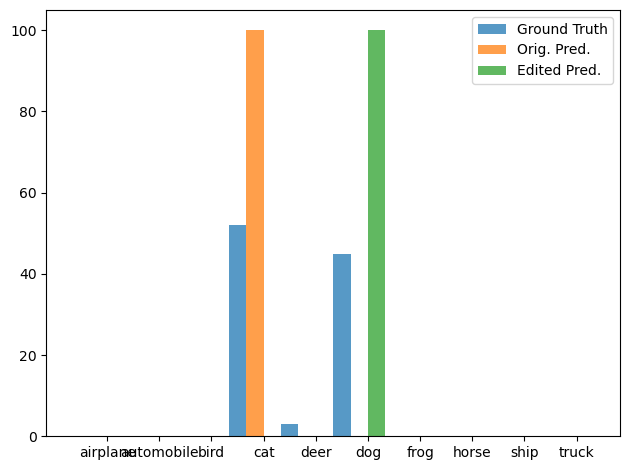

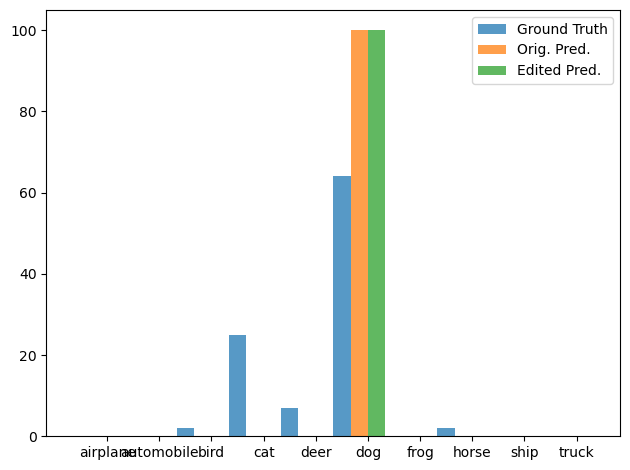

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_1/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_1/models
Finished trial 34/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_1
Starting Trial 35/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/watershed_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modifie

100%|██████████████████████████████████████████| 274/274 [02:28<00:00,  1.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.06383322179317474 0.003863358171656728
L2 norm of weight change: 0.20556434988975525
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:45<00:00,  1.66it/s]


Post-edit metrics: {'TP': array([6058, 5560, 5294, 3176, 4273, 3615, 5628, 5139, 4952, 4456]), 'TN': array([60452, 60777, 59083, 61157, 60080, 60757, 61113, 61770, 61424,
       61538]), 'FPs': array([2548, 2223, 3917, 1843, 2920, 2243, 1887, 1230, 1576, 1462]), 'FNs': array([ 942, 1440, 1706, 3824, 2727, 3385, 1372, 1861, 2048, 2544]), 'accuracy': 0.6878714285714286, 'per_class_accuracy': array([0.95014286, 0.94767143, 0.91967143, 0.91904286, 0.91932857,
       0.9196    , 0.95344286, 0.95584286, 0.94822857, 0.94277143]), 'per_class_accuracy_mean': 0.9375742857142857, 'precision': array([0.70392749, 0.71437749, 0.57474758, 0.63279538, 0.59404977,
       0.61710481, 0.7489022 , 0.80687706, 0.75857843, 0.75295708]), 'precision_mean': 0.6904317296201314, 'recall': array([0.86542857, 0.79428571, 0.75628571, 0.45371429, 0.61042857,
       0.51642857, 0.804     , 0.73414286, 0.70742857, 0.63657143]), 'recall_mean': 0.6878714285714285, 'f1': array([0.77636806, 0.75221538, 0.65313676, 0.52849

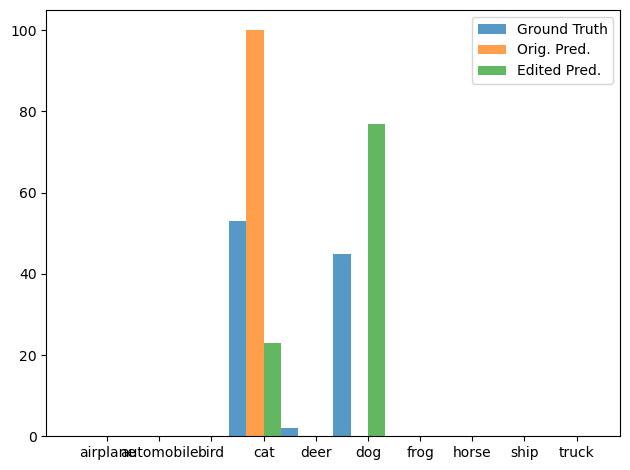

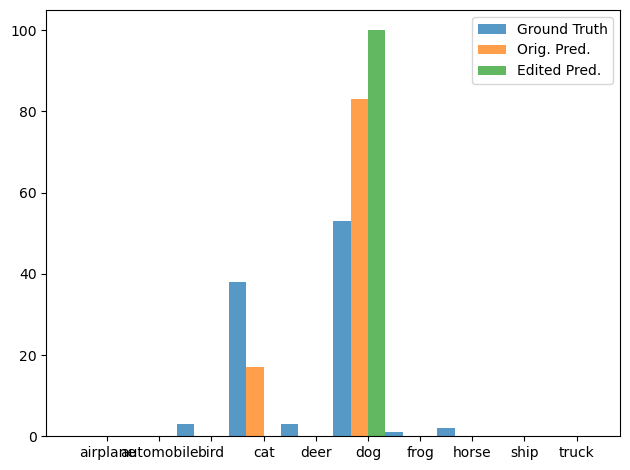

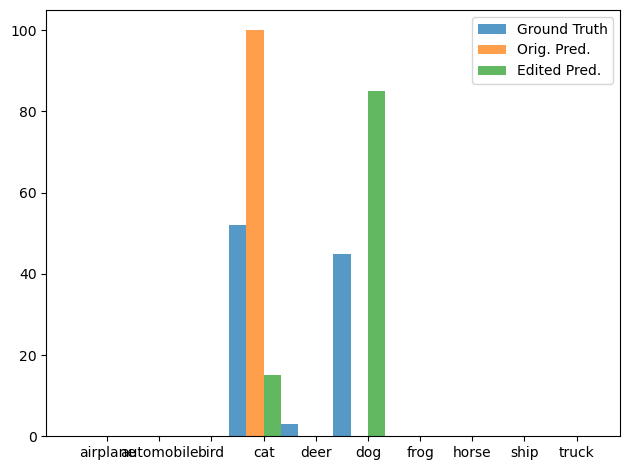

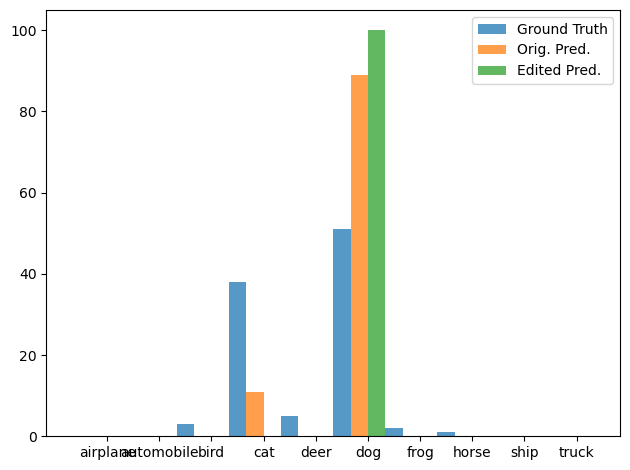

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_2/models
Finished trial 35/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_2
Starting Trial 36/37...
Current run_id: 0112_121958/dog-train-n02113624_8298/watershed_masked_3
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02113624_8298.png
Value images: saved/segmentations/dog-train-n02113624_8298/modifie

100%|██████████████████████████████████████████| 274/274 [03:06<00:00,  1.47it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.12368272989988327 0.006793797016143799
L2 norm of weight change: 0.35195037722587585
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [03:26<00:00,  1.33it/s]


Post-edit metrics: {'TP': array([6032, 5609, 5656, 2181, 4358, 3528, 5575, 5099, 4899, 4275]), 'TN': array([60471, 60687, 56771, 62386, 59800, 60957, 61106, 61824, 61442,
       61768]), 'FPs': array([2529, 2313, 6229,  614, 3200, 2043, 1894, 1176, 1558, 1232]), 'FNs': array([ 968, 1391, 1344, 4819, 2642, 3472, 1425, 1901, 2101, 2725]), 'accuracy': 0.6744571428571429, 'per_class_accuracy': array([0.95004286, 0.94708571, 0.89181429, 0.92238571, 0.91654286,
       0.92121429, 0.95258571, 0.95604286, 0.94772857, 0.94347143]), 'per_class_accuracy_mean': 0.9348914285714285, 'precision': array([0.70459059, 0.70802828, 0.47589398, 0.780322  , 0.57660757,
       0.63327948, 0.74641853, 0.81258964, 0.75871148, 0.77628473]), 'precision_mean': 0.6972726275471006, 'recall': array([0.86171429, 0.80128571, 0.808     , 0.31157143, 0.62257143,
       0.504     , 0.79642857, 0.72842857, 0.69985714, 0.61071429]), 'recall_mean': 0.6744571428571429, 'f1': array([0.77527151, 0.7517759 , 0.59899391, 0.44532

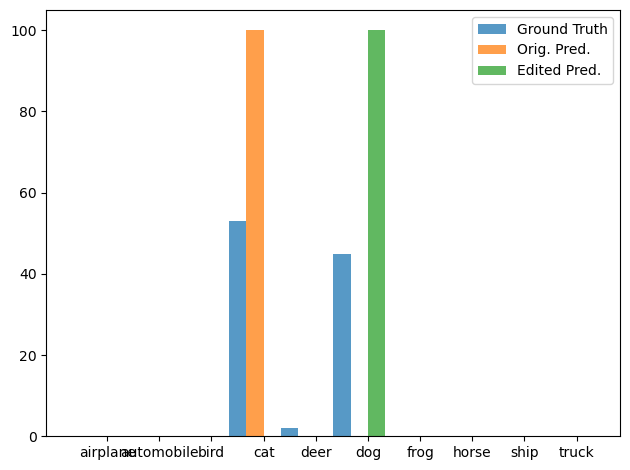

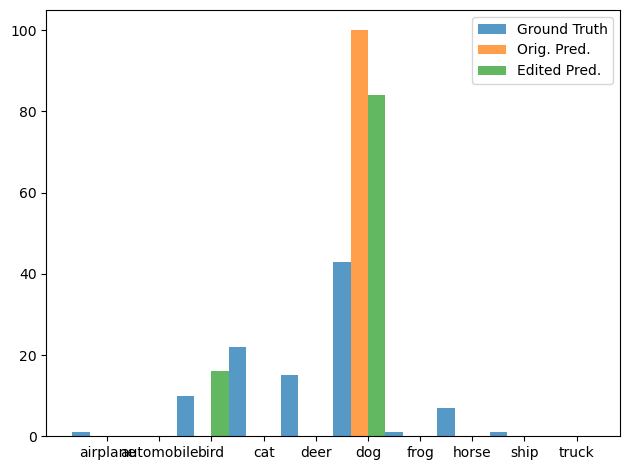

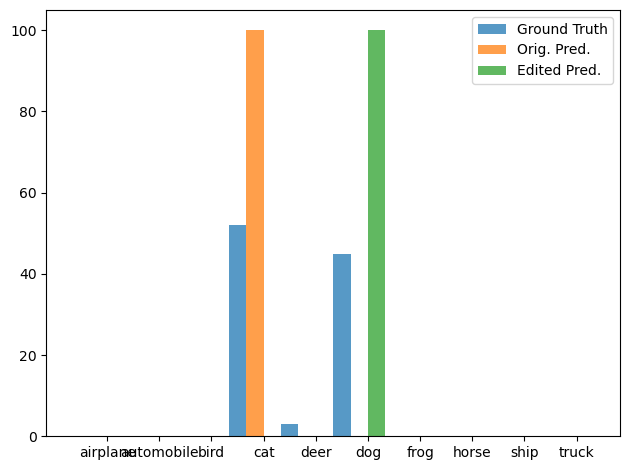

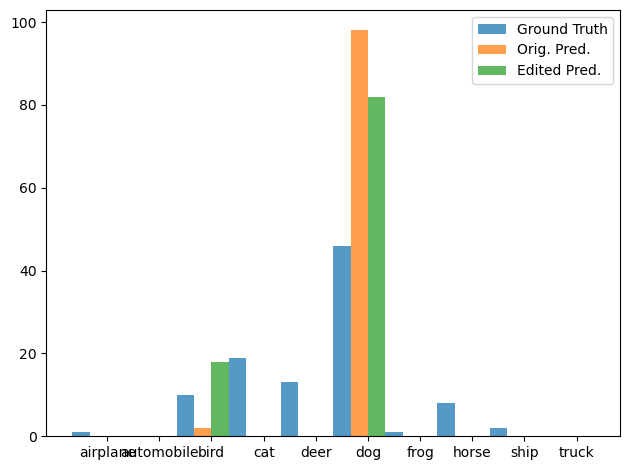

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_3/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_3/models
Finished trial 36/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02113624_8298/watershed_masked_3
Starting Trial 37/37...
Current run_id: 0112_121958/dog-train-n02087394_1173/slic_masked_2
saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_1173/slic_masked_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02087394_1173.png
Value images: saved/segmentations/dog-train-n02087394_1173/modified_images/s

100%|██████████████████████████████████████████| 274/274 [03:05<00:00,  1.48it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5203, 3842, 4270, 2990, 5659, 5136, 4820, 4679]), 'TN': array([60115, 61110, 59441, 59902, 60157, 61756, 61050, 61747, 61643,
       61202]), 'FPs': array([2885, 1890, 3559, 3098, 2843, 1244, 1950, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1797, 3158, 2730, 4010, 1341, 1864, 2180, 2321]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92348571, 0.91062857, 0.92038571,
       0.92494286, 0.95298571, 0.95547143, 0.94947143, 0.94115714]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68040323, 0.74009901, 0.5938142 , 0.55360231, 0.60030929,
       0.706188  , 0.74372454, 0.80388167, 0.78031407, 0.72240235]), 'precision_mean': 0.6924738665961387, 'recall': array([0.87742857, 0.76885714, 0.74328571, 0.54885714, 0.61      ,
       0.42714286, 0.80842857, 0.73371429, 0.68857143, 0.66842857]), 'recall_mean': 0.6874714285714286, 'f1': array([0.7664566 , 0.75420404, 0.66019541, 0.551219

tensor(0.0143, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:

Loss (orig, final): 0.1168128103017807 0.014334168285131454
L2 norm of weight change: 0.3407079577445984
Performing post-edit metric & KNN calculations on validation set.



100%|██████████████████████████████████████████| 274/274 [02:32<00:00,  1.79it/s]


Post-edit metrics: {'TP': array([6027, 5696, 5246, 3710, 3603, 3901, 5743, 3900, 5028, 4248]), 'TN': array([60558, 60340, 59329, 60071, 61448, 58919, 60788, 62747, 61150,
       61752]), 'FPs': array([2442, 2660, 3671, 2929, 1552, 4081, 2212,  253, 1850, 1248]), 'FNs': array([ 973, 1304, 1754, 3290, 3397, 3099, 1257, 3100, 1972, 2752]), 'accuracy': 0.6728857142857143, 'per_class_accuracy': array([0.95121429, 0.94337143, 0.9225    , 0.91115714, 0.9293    ,
       0.89742857, 0.95044286, 0.9521    , 0.9454    , 0.94285714]), 'per_class_accuracy_mean': 0.9345771428571428, 'precision': array([0.71165427, 0.68166587, 0.58831446, 0.5588191 , 0.69893307,
       0.48872463, 0.72193589, 0.93908018, 0.73102646, 0.77292576]), 'precision_mean': 0.6893079694995672, 'recall': array([0.861     , 0.81371429, 0.74942857, 0.53      , 0.51471429,
       0.55728571, 0.82042857, 0.55714286, 0.71828571, 0.60685714]), 'recall_mean': 0.6728857142857143, 'f1': array([0.77923589, 0.74185986, 0.65916944, 0.54402

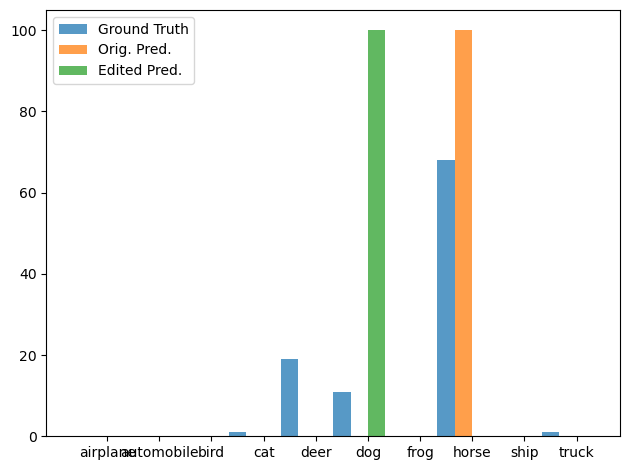

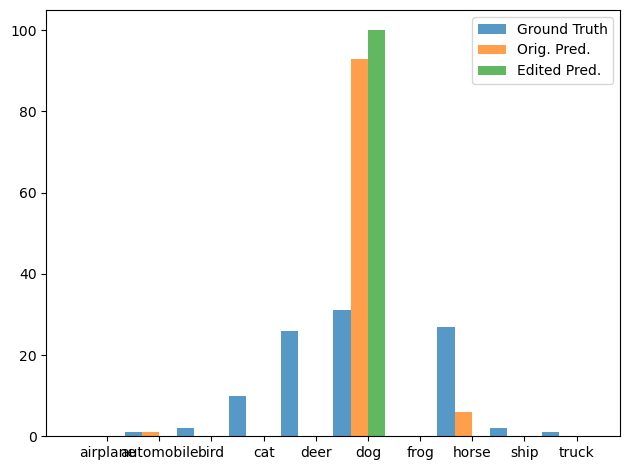

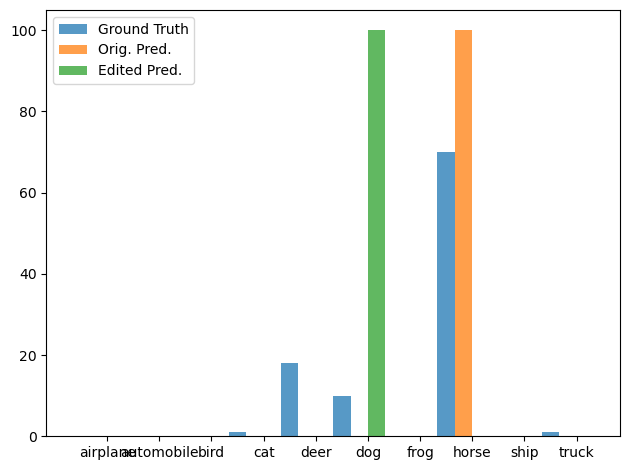

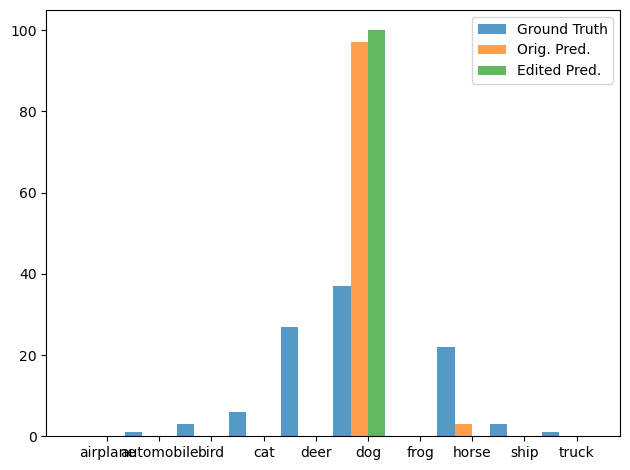

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_1173/slic_masked_2/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_1173/slic_masked_2/models
Finished trial 37/37. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02087394_1173/slic_masked_2


In [13]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("Starting Trial {}/{}...".format(idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [21]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [22]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/trial_paths.txt


## Analyze KNN

In [23]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


Starting KNN analysis...


0it [00:00, ?it/s]

Processing 1/37 trials. Currently processing felzenszwalb_gaussian_0
Analyzing KNN results from saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models
Logging and saving visualizations to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_visualizations/knn_analysis_log.txt
Saving results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/knn_analysis_results.pth


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/dog-train-n02114712_211/felzenszwalb_gaussian_0/models/edited_model.pth'

## Convert to CSV for all trials

In [24]:
data = []
# Iterate through all trials
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # Obtain key ID from path
    key_id = os.path.basename(os.path.dirname(trial_dir))
    id_class = key_id.split('-')[0]
    if id_class not in class_list:
        raise ValueError("Invalid key_id {}".format(key_id))
    # Obtain value ID from path
    val_id = os.path.basename(trial_dir)
    # Join to make a data ID
    data_id = os.path.join(key_id, val_id)
    
    # Load results from knn, pre-edit metrics, and post-edit metrics
    restore_dir = os.path.join(trial_dir, 'models')
    knn_analysis_results = torch.load(os.path.join(restore_dir, knn_analysis_filename))
    pre_edit_metrics = torch.load(os.path.join(restore_dir, 'pre_edit_metrics.pth'))
    post_edit_metrics = torch.load(os.path.join(restore_dir, 'post_edit_metrics.pth'))
    
    # Combine results into one dictionary
    combined_results = combine_results(
        data_id=data_id,
        knn_analysis=knn_analysis_results,
        pre_edit_metrics=pre_edit_metrics,
        post_edit_metrics=post_edit_metrics)
    
    # Save column headers in first trial run
    if trial_idx == 0:
        column_headers = list(combined_results.keys())
    # Convert results to np.array & append to list
    combined_results = np.expand_dims(np.array(list(combined_results.values())), axis=0)
    data.append(combined_results)

# Convert data from list of np.arrays -> pd.DataFrame    
data = np.concatenate(data, axis=0)
df = pd.DataFrame(data, columns=column_headers)


37it [00:01, 23.99it/s]


In [25]:
# Save to CSV
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
df.to_csv(csv_save_path)
print("Saved CSV to {}".format(csv_save_path))

Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0112_121958/results_table.csv
